In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
from june import World 
from june.demography.geography import Geography
from june.demography import Demography
from june.interaction import ContactAveraging
from june.infection import Infection
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries
from june.simulator import Simulator
from june.infection_seed import InfectionSeed
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.logger.read_logger import ReadLogger
from june.infection.infection import InfectionSelector
from june.world import generate_world_from_hdf5, generate_world_from_geography

No --data argument given - defaulting to:
/home/florpi/JUNE/data
No --configs argument given - defaulting to:
/home/florpi/JUNE/configs


# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [4]:
CONFIG_PATH = "../configs/config_example.yaml"

In [5]:
%%time 

geography = Geography.from_file(
        {
            "super_area": [
                "E02003282",
                "E02001720",
                "E00088544",
                "E02002560",
                "E02002559",
                "E02004314",
            ]
        }
)

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
geography.universities = Universities.for_super_areas(geography.super_areas)
world = generate_world_from_geography(geography, include_households=True, include_commute=True)

2020-07-10 16:55:16,142 - june.demography.geography - INFO - There are 129 areas and 5 super_areas in the world.
2020-07-10 16:55:16,148 - june.groups.hospital - INFO - There are 1 hospitals in this geography.
2020-07-10 16:55:16,227 - june.groups.school - INFO - There are 19 schools in this geography.
2020-07-10 16:55:16,287 - june.groups.school - INFO - No school for the age 0 in this world.
2020-07-10 16:55:16,294 - june.groups.school - INFO - No school for the age 1 in this world.
2020-07-10 16:55:16,299 - june.groups.school - INFO - No school for the age 2 in this world.
2020-07-10 16:55:16,664 - june.groups.carehome - INFO - There are 9 care_homes in this geography.
2020-07-10 16:55:24,251 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.
2020-07-10 16:55:29,866 - june.distributors.worker_distributor - INFO - There are 0 who had to be told to stay real
CPU times: user 40.5 s, sys: 1.48 s, total: 42 s
Wall time: 43 s


## Commute, travel and leisure

In [6]:
world.pubs = Pubs.for_geography(geography)
world.cinemas = Cinemas.for_geography(geography)
world.groceries = Groceries.for_geography(geography)
leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_households(world.households) # this assigns possible social venues to people.

We are also going to need some cemeteries...geography.cemeteries = Cemeteries()


In [7]:
world.cemeteries = Cemeteries()

In [8]:
len(world.people)

46784

### If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later.

In [9]:
world.to_hdf5("world.hdf5")

If we would like to load the world we saved, we just do

In [10]:
world = generate_world_from_hdf5("world.hdf5")

loading population from hdf5 .
loading companies from hdf5 .
loading households from hdf5 .

  0%|          | 0/46784 [00:00<?, ?it/s]


restoring world...


100%|██████████| 46784/46784 [00:00<00:00, 49758.18it/s]


In [11]:
world.pubs

In [12]:
# and regenerate leisure in case we load it externally
leisure = generate_leisure_for_config(world, CONFIG_PATH)

you have now a beautiful pre-pandemic world. 

# Adding the infection

Now, you can play around with different models of infections. The building blocks for an infection are: Transmission and Symptoms. For now, only SymptomsConstant and TransmissionConstant are in a state to be used.

In [13]:
selector = InfectionSelector.from_file()

# Adding the interaction

In [14]:
interaction = ContactAveraging.from_file(selector=selector)

Beta are the intensities of the interaction taking place at the different groups

In [15]:
interaction.beta

{'box': 1,
 'pub': 0.1,
 'grocery': 0.1,
 'cinema': 0.1,
 'commute_unit': 1.0,
 'commute_city_unit': 1.0,
 'hospital': 1.0,
 'care_home': 1.0,
 'company': 0.1,
 'school': 0.1,
 'household': 0.2,
 'university': 0.01}

to modify these, simply do

In [16]:
#interaction.beta['household'] =0.05
#interaction.beta['company'] =0.05
#interaction.beta['university'] =0.05
#interaction.beta['school'] =0.05
#interaction.beta['commute_unit'] =0.1
#interaction.beta['commute_city_unit'] =0.1
#interaction.beta['hospital'] =0.1

#interaction.beta['care_home'] =0.1
#interaction.beta['pub'] =0.01
#interaction.beta['cinema'] =0.01
#interaction.beta['grocery'] =0.01

In [17]:
interaction.beta

{'box': 1,
 'pub': 0.1,
 'grocery': 0.1,
 'cinema': 0.1,
 'commute_unit': 1.0,
 'commute_city_unit': 1.0,
 'hospital': 1.0,
 'care_home': 1.0,
 'company': 0.1,
 'school': 0.1,
 'household': 0.2,
 'university': 0.01}

moreover this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [18]:
interaction.alpha_physical

2.0

In [19]:
interaction.alpha_physical /= 2

In [20]:
interaction.alpha_physical

1.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [21]:
infection_seed = InfectionSeed(world.super_areas, selector,)

In [22]:
n_cases = 50
infection_seed.unleash_virus(n_cases) # play around with the initial number of cases

# Set policies

In [23]:
policies = Policies.from_file()

# Run the simulation

Since the timer configuration is a bit cumbersome, it is read from the config file at ``configs/config_example.yaml``

In [24]:
simulator = Simulator.from_file(
     world, interaction, selector, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    policies = policies
)

In [25]:
%%time
simulator.run()

2020-07-10 16:56:23,303 - june.simulator - INFO - Starting group_dynamics for 250 days at day 0
2020-07-10 16:56:23,305 - june.simulator - INFO - starting the loop ..., at 0 days, to run for 250 days
2020-07-10 16:56:24,764 - june.simulator - INFO - Date = 2020-03-01 04:00:00, number of deaths =  0, number of infected = 50
2020-07-10 16:56:25,852 - june.simulator - INFO - Date = 2020-03-01 08:00:00, number of deaths =  0, number of infected = 50
2020-07-10 16:56:26,428 - june.simulator - INFO - Date = 2020-03-01 12:00:00, number of deaths =  0, number of infected = 50
2020-07-10 16:56:27,054 - june.simulator - INFO - Date = 2020-03-02 00:00:00, number of deaths =  0, number of infected = 50
2020-07-10 16:56:27,643 - june.simulator - INFO - Date = 2020-03-02 01:00:00, number of deaths =  0, number of infected = 50
2020-07-10 16:56:28,094 - june.simulator - INFO - Date = 2020-03-02 05:00:00, number of deaths =  0, number of infected = 50
2020-07-10 16:56:28,526 - june.simulator - INFO - 

2020-07-10 16:57:12,933 - june.simulator - INFO - Date = 2020-03-12 13:00:00, number of deaths =  0, number of infected = 1499
2020-07-10 16:57:13,853 - june.simulator - INFO - Date = 2020-03-13 00:00:00, number of deaths =  0, number of infected = 1633
2020-07-10 16:57:14,519 - june.simulator - INFO - Date = 2020-03-13 01:00:00, number of deaths =  0, number of infected = 1654
2020-07-10 16:57:15,244 - june.simulator - INFO - Date = 2020-03-13 05:00:00, number of deaths =  0, number of infected = 1727
2020-07-10 16:57:15,880 - june.simulator - INFO - Date = 2020-03-13 09:00:00, number of deaths =  0, number of infected = 1807
2020-07-10 16:57:16,739 - june.simulator - INFO - Date = 2020-03-13 10:00:00, number of deaths =  0, number of infected = 1833
2020-07-10 16:57:17,506 - june.simulator - INFO - Date = 2020-03-13 13:00:00, number of deaths =  0, number of infected = 1915
2020-07-10 16:57:18,779 - june.simulator - INFO - Date = 2020-03-14 00:00:00, number of deaths =  0, number of 

2020-07-10 16:58:39,772 - june.simulator - INFO - Date = 2020-03-25 00:00:00, number of deaths =  5, number of infected = 6215
2020-07-10 16:58:41,829 - june.simulator - INFO - Date = 2020-03-25 01:00:00, number of deaths =  5, number of infected = 6228
2020-07-10 16:58:43,768 - june.simulator - INFO - Date = 2020-03-25 05:00:00, number of deaths =  5, number of infected = 6279
2020-07-10 16:58:45,444 - june.simulator - INFO - Date = 2020-03-25 09:00:00, number of deaths =  7, number of infected = 6319
2020-07-10 16:58:47,149 - june.simulator - INFO - Date = 2020-03-25 10:00:00, number of deaths =  7, number of infected = 6330
2020-07-10 16:58:48,633 - june.simulator - INFO - Date = 2020-03-25 13:00:00, number of deaths =  8, number of infected = 6370
2020-07-10 16:58:50,702 - june.simulator - INFO - Date = 2020-03-26 00:00:00, number of deaths =  8, number of infected = 6475
2020-07-10 16:58:52,562 - june.simulator - INFO - Date = 2020-03-26 01:00:00, number of deaths =  8, number of 

2020-07-10 17:00:47,070 - june.simulator - INFO - Date = 2020-04-06 01:00:00, number of deaths =  43, number of infected = 6972
2020-07-10 17:00:49,048 - june.simulator - INFO - Date = 2020-04-06 05:00:00, number of deaths =  43, number of infected = 6945
2020-07-10 17:00:50,539 - june.simulator - INFO - Date = 2020-04-06 09:00:00, number of deaths =  43, number of infected = 6935
2020-07-10 17:00:52,399 - june.simulator - INFO - Date = 2020-04-06 10:00:00, number of deaths =  43, number of infected = 6928
2020-07-10 17:00:54,052 - june.simulator - INFO - Date = 2020-04-06 13:00:00, number of deaths =  44, number of infected = 6901
2020-07-10 17:00:55,560 - june.simulator - INFO - Date = 2020-04-07 00:00:00, number of deaths =  45, number of infected = 6813
2020-07-10 17:00:56,986 - june.simulator - INFO - Date = 2020-04-07 01:00:00, number of deaths =  45, number of infected = 6798
2020-07-10 17:00:58,632 - june.simulator - INFO - Date = 2020-04-07 05:00:00, number of deaths =  45, nu

2020-07-10 17:02:38,816 - june.simulator - INFO - Date = 2020-04-17 10:00:00, number of deaths =  56, number of infected = 4802
2020-07-10 17:02:40,272 - june.simulator - INFO - Date = 2020-04-17 13:00:00, number of deaths =  56, number of infected = 4791
2020-07-10 17:02:42,140 - june.simulator - INFO - Date = 2020-04-18 00:00:00, number of deaths =  56, number of infected = 4722
2020-07-10 17:02:43,460 - june.simulator - INFO - Date = 2020-04-18 04:00:00, number of deaths =  56, number of infected = 4694
2020-07-10 17:02:44,899 - june.simulator - INFO - Date = 2020-04-18 08:00:00, number of deaths =  56, number of infected = 4682
2020-07-10 17:02:45,931 - june.simulator - INFO - Date = 2020-04-18 12:00:00, number of deaths =  56, number of infected = 4638
2020-07-10 17:02:47,409 - june.simulator - INFO - Date = 2020-04-19 00:00:00, number of deaths =  56, number of infected = 4561
2020-07-10 17:02:48,784 - june.simulator - INFO - Date = 2020-04-19 04:00:00, number of deaths =  56, nu

2020-07-10 17:04:17,078 - june.simulator - INFO - Date = 2020-04-29 13:00:00, number of deaths =  62, number of infected = 3108
2020-07-10 17:04:18,636 - june.simulator - INFO - Date = 2020-04-30 00:00:00, number of deaths =  62, number of infected = 3051
2020-07-10 17:04:20,375 - june.simulator - INFO - Date = 2020-04-30 01:00:00, number of deaths =  62, number of infected = 3048
2020-07-10 17:04:22,145 - june.simulator - INFO - Date = 2020-04-30 05:00:00, number of deaths =  63, number of infected = 3037
2020-07-10 17:04:23,495 - june.simulator - INFO - Date = 2020-04-30 09:00:00, number of deaths =  63, number of infected = 3015
2020-07-10 17:04:25,156 - june.simulator - INFO - Date = 2020-04-30 10:00:00, number of deaths =  63, number of infected = 3011
2020-07-10 17:04:26,548 - june.simulator - INFO - Date = 2020-04-30 13:00:00, number of deaths =  63, number of infected = 2998
2020-07-10 17:04:28,132 - june.simulator - INFO - Date = 2020-05-01 00:00:00, number of deaths =  63, nu

2020-07-10 17:05:52,969 - june.simulator - INFO - Date = 2020-05-12 00:00:00, number of deaths =  67, number of infected = 1969
2020-07-10 17:05:54,710 - june.simulator - INFO - Date = 2020-05-12 01:00:00, number of deaths =  67, number of infected = 1967
2020-07-10 17:05:56,533 - june.simulator - INFO - Date = 2020-05-12 05:00:00, number of deaths =  67, number of infected = 1952
2020-07-10 17:05:58,005 - june.simulator - INFO - Date = 2020-05-12 09:00:00, number of deaths =  67, number of infected = 1937
2020-07-10 17:05:59,828 - june.simulator - INFO - Date = 2020-05-12 10:00:00, number of deaths =  67, number of infected = 1936
2020-07-10 17:06:01,291 - june.simulator - INFO - Date = 2020-05-12 13:00:00, number of deaths =  67, number of infected = 1937
2020-07-10 17:06:02,763 - june.simulator - INFO - Date = 2020-05-13 00:00:00, number of deaths =  67, number of infected = 1902
2020-07-10 17:06:04,567 - june.simulator - INFO - Date = 2020-05-13 01:00:00, number of deaths =  67, nu

2020-07-10 17:07:33,905 - june.simulator - INFO - Date = 2020-05-23 12:00:00, number of deaths =  69, number of infected = 1273
2020-07-10 17:07:35,392 - june.simulator - INFO - Date = 2020-05-24 00:00:00, number of deaths =  69, number of infected = 1252
2020-07-10 17:07:36,859 - june.simulator - INFO - Date = 2020-05-24 04:00:00, number of deaths =  69, number of infected = 1240
2020-07-10 17:07:38,567 - june.simulator - INFO - Date = 2020-05-24 08:00:00, number of deaths =  69, number of infected = 1238
2020-07-10 17:07:39,947 - june.simulator - INFO - Date = 2020-05-24 12:00:00, number of deaths =  69, number of infected = 1237
2020-07-10 17:07:41,342 - june.simulator - INFO - Date = 2020-05-25 00:00:00, number of deaths =  69, number of infected = 1212
2020-07-10 17:07:43,279 - june.simulator - INFO - Date = 2020-05-25 01:00:00, number of deaths =  69, number of infected = 1210
2020-07-10 17:07:45,098 - june.simulator - INFO - Date = 2020-05-25 05:00:00, number of deaths =  69, nu

2020-07-10 17:09:16,393 - june.simulator - INFO - Date = 2020-06-04 10:00:00, number of deaths =  71, number of infected = 844
2020-07-10 17:09:17,694 - june.simulator - INFO - Date = 2020-06-04 13:00:00, number of deaths =  71, number of infected = 840
2020-07-10 17:09:18,969 - june.simulator - INFO - Date = 2020-06-05 00:00:00, number of deaths =  71, number of infected = 828
2020-07-10 17:09:20,239 - june.simulator - INFO - Date = 2020-06-05 01:00:00, number of deaths =  71, number of infected = 827
2020-07-10 17:09:21,594 - june.simulator - INFO - Date = 2020-06-05 05:00:00, number of deaths =  71, number of infected = 821
2020-07-10 17:09:22,605 - june.simulator - INFO - Date = 2020-06-05 09:00:00, number of deaths =  71, number of infected = 819
2020-07-10 17:09:23,840 - june.simulator - INFO - Date = 2020-06-05 10:00:00, number of deaths =  71, number of infected = 814
2020-07-10 17:09:24,786 - june.simulator - INFO - Date = 2020-06-05 13:00:00, number of deaths =  71, number of

2020-07-10 17:10:46,695 - june.simulator - INFO - Date = 2020-06-16 13:00:00, number of deaths =  72, number of infected = 597
2020-07-10 17:10:48,095 - june.simulator - INFO - Date = 2020-06-17 00:00:00, number of deaths =  72, number of infected = 596
2020-07-10 17:10:49,885 - june.simulator - INFO - Date = 2020-06-17 01:00:00, number of deaths =  72, number of infected = 596
2020-07-10 17:10:51,539 - june.simulator - INFO - Date = 2020-06-17 05:00:00, number of deaths =  72, number of infected = 594
2020-07-10 17:10:52,984 - june.simulator - INFO - Date = 2020-06-17 09:00:00, number of deaths =  72, number of infected = 594
2020-07-10 17:10:54,624 - june.simulator - INFO - Date = 2020-06-17 10:00:00, number of deaths =  72, number of infected = 596
2020-07-10 17:10:56,037 - june.simulator - INFO - Date = 2020-06-17 13:00:00, number of deaths =  72, number of infected = 594
2020-07-10 17:10:57,471 - june.simulator - INFO - Date = 2020-06-18 00:00:00, number of deaths =  72, number of

2020-07-10 17:12:21,246 - june.simulator - INFO - Date = 2020-06-29 00:00:00, number of deaths =  74, number of infected = 438
2020-07-10 17:12:22,707 - june.simulator - INFO - Date = 2020-06-29 01:00:00, number of deaths =  74, number of infected = 438
2020-07-10 17:12:24,036 - june.simulator - INFO - Date = 2020-06-29 05:00:00, number of deaths =  74, number of infected = 436
2020-07-10 17:12:25,547 - june.simulator - INFO - Date = 2020-06-29 09:00:00, number of deaths =  74, number of infected = 440
2020-07-10 17:12:27,279 - june.simulator - INFO - Date = 2020-06-29 10:00:00, number of deaths =  74, number of infected = 441
2020-07-10 17:12:28,771 - june.simulator - INFO - Date = 2020-06-29 13:00:00, number of deaths =  74, number of infected = 439
2020-07-10 17:12:30,188 - june.simulator - INFO - Date = 2020-06-30 00:00:00, number of deaths =  74, number of infected = 437
2020-07-10 17:12:32,143 - june.simulator - INFO - Date = 2020-06-30 01:00:00, number of deaths =  74, number of

2020-07-10 17:13:39,678 - june.simulator - INFO - Date = 2020-07-10 09:00:00, number of deaths =  75, number of infected = 294
2020-07-10 17:13:40,849 - june.simulator - INFO - Date = 2020-07-10 10:00:00, number of deaths =  75, number of infected = 293
2020-07-10 17:13:41,664 - june.simulator - INFO - Date = 2020-07-10 13:00:00, number of deaths =  75, number of infected = 296
2020-07-10 17:13:42,804 - june.simulator - INFO - Date = 2020-07-11 00:00:00, number of deaths =  75, number of infected = 295
2020-07-10 17:13:43,816 - june.simulator - INFO - Date = 2020-07-11 04:00:00, number of deaths =  75, number of infected = 299
2020-07-10 17:13:44,967 - june.simulator - INFO - Date = 2020-07-11 08:00:00, number of deaths =  75, number of infected = 300
2020-07-10 17:13:45,679 - june.simulator - INFO - Date = 2020-07-11 12:00:00, number of deaths =  75, number of infected = 304
2020-07-10 17:13:46,821 - june.simulator - INFO - Date = 2020-07-12 00:00:00, number of deaths =  75, number of

2020-07-10 17:14:42,770 - june.simulator - INFO - Date = 2020-07-22 10:00:00, number of deaths =  75, number of infected = 558
2020-07-10 17:14:43,684 - june.simulator - INFO - Date = 2020-07-22 13:00:00, number of deaths =  75, number of infected = 567
2020-07-10 17:14:44,673 - june.simulator - INFO - Date = 2020-07-23 00:00:00, number of deaths =  75, number of infected = 579
2020-07-10 17:14:45,689 - june.simulator - INFO - Date = 2020-07-23 01:00:00, number of deaths =  75, number of infected = 586
2020-07-10 17:14:46,705 - june.simulator - INFO - Date = 2020-07-23 05:00:00, number of deaths =  75, number of infected = 612
2020-07-10 17:14:47,586 - june.simulator - INFO - Date = 2020-07-23 09:00:00, number of deaths =  75, number of infected = 637
2020-07-10 17:14:48,745 - june.simulator - INFO - Date = 2020-07-23 10:00:00, number of deaths =  75, number of infected = 640
2020-07-10 17:14:49,373 - june.simulator - INFO - Date = 2020-07-23 13:00:00, number of deaths =  75, number of

KeyboardInterrupt: 

While the simulation runs (and afterwards) we can launch the visualization webpage by running
```python june/visualizer.py path/to/results``` 

# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [26]:
import pandas as pd

In [27]:
read = ReadLogger()

## Hospital data and how it changed over time

In [28]:
hospitals_df = read.load_hospital_capacity()

In [29]:
hospitals_df.head(3)

,time_stamp,id,n_patients,n_patients_icu
0,2020-03-01T04:00:00.000000,0,0,0
1,2020-03-01T08:00:00.000000,0,0,0
2,2020-03-01T12:00:00.000000,0,0,0


In [30]:
hospitals_characteristics_df = read.load_hospital_characteristics()

In [31]:
hospitals_characteristics_df

,longitude,latitude,n_beds,n_icu_beds,trust_code
0,0.688477,51.5625,2115,296,RAJ


## where did infections happen?

In [32]:
loc_df = read.get_locations_infections()

In [33]:
locations_per_day = read.locations_df.groupby(pd.Grouper(freq='D')).sum()

In [34]:
all_infection_places = set(locations_per_day.location.sum())

In [35]:
def n_infections(row, infection_place):
    return sum([row.counts[i] for i, x in enumerate(row.location) if x == infection_place])


In [36]:
for infection_place in all_infection_places:
    locations_per_day[str(infection_place)] = locations_per_day.apply(
        lambda x: n_infections(x, infection_place),
        axis=1
    )

In [37]:
locations_per_day = locations_per_day.drop(columns=['location',
                                                    'counts'])

In [38]:
locations_per_day = locations_per_day.div(
    locations_per_day.sum(axis=1), axis=0
)


Text(0, 0.5, 'Percent of infections')

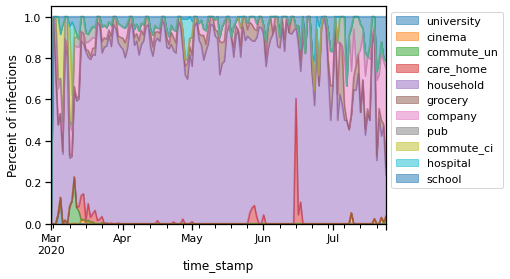

In [39]:
locations_per_day.plot.area( alpha=0.5)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Percent of infections')

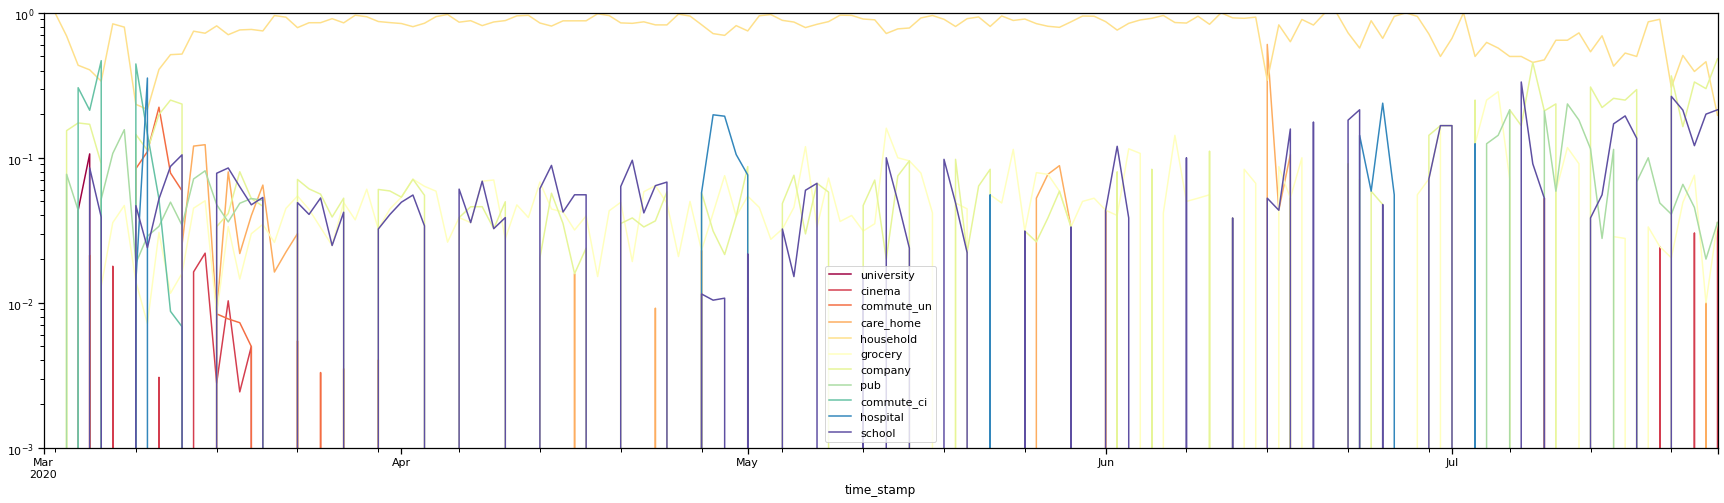

In [40]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

locations_per_day.plot(figsize=(30,8), logy=True, ylim=(1e-3, 1), cmap=cmap)

Text(0.5, 0, 'location')

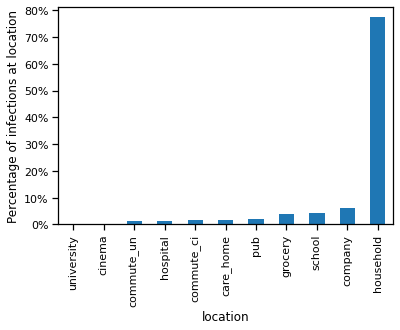

In [41]:
import matplotlib.ticker as mtick

ax = loc_df['percentage_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')
#plt.yscale('log')

## rate of infection

In [42]:
r_df = read.get_r()

/home/florpi/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/florpi/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'R')

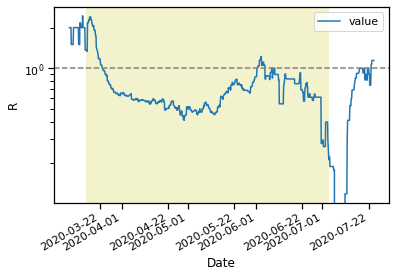

In [43]:
r_df.plot()
plt.axvspan(policies.social_distancing_start, 
            policies.social_distancing_end,
            facecolor='y', alpha=0.2)
plt.axhline(y=1, linestyle='dashed', color='gray')
plt.xlabel('Date')
plt.yscale('log')
plt.ylabel('R')

## World infection curves, and by super area

In [44]:
world_df = read.world_summary()

In [45]:
import matplotlib.pyplot as plt
 
plt.style.use(['science','notebook'])
plt.style.reload_library()

In [46]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

Text(0.5, 0, 'Date')

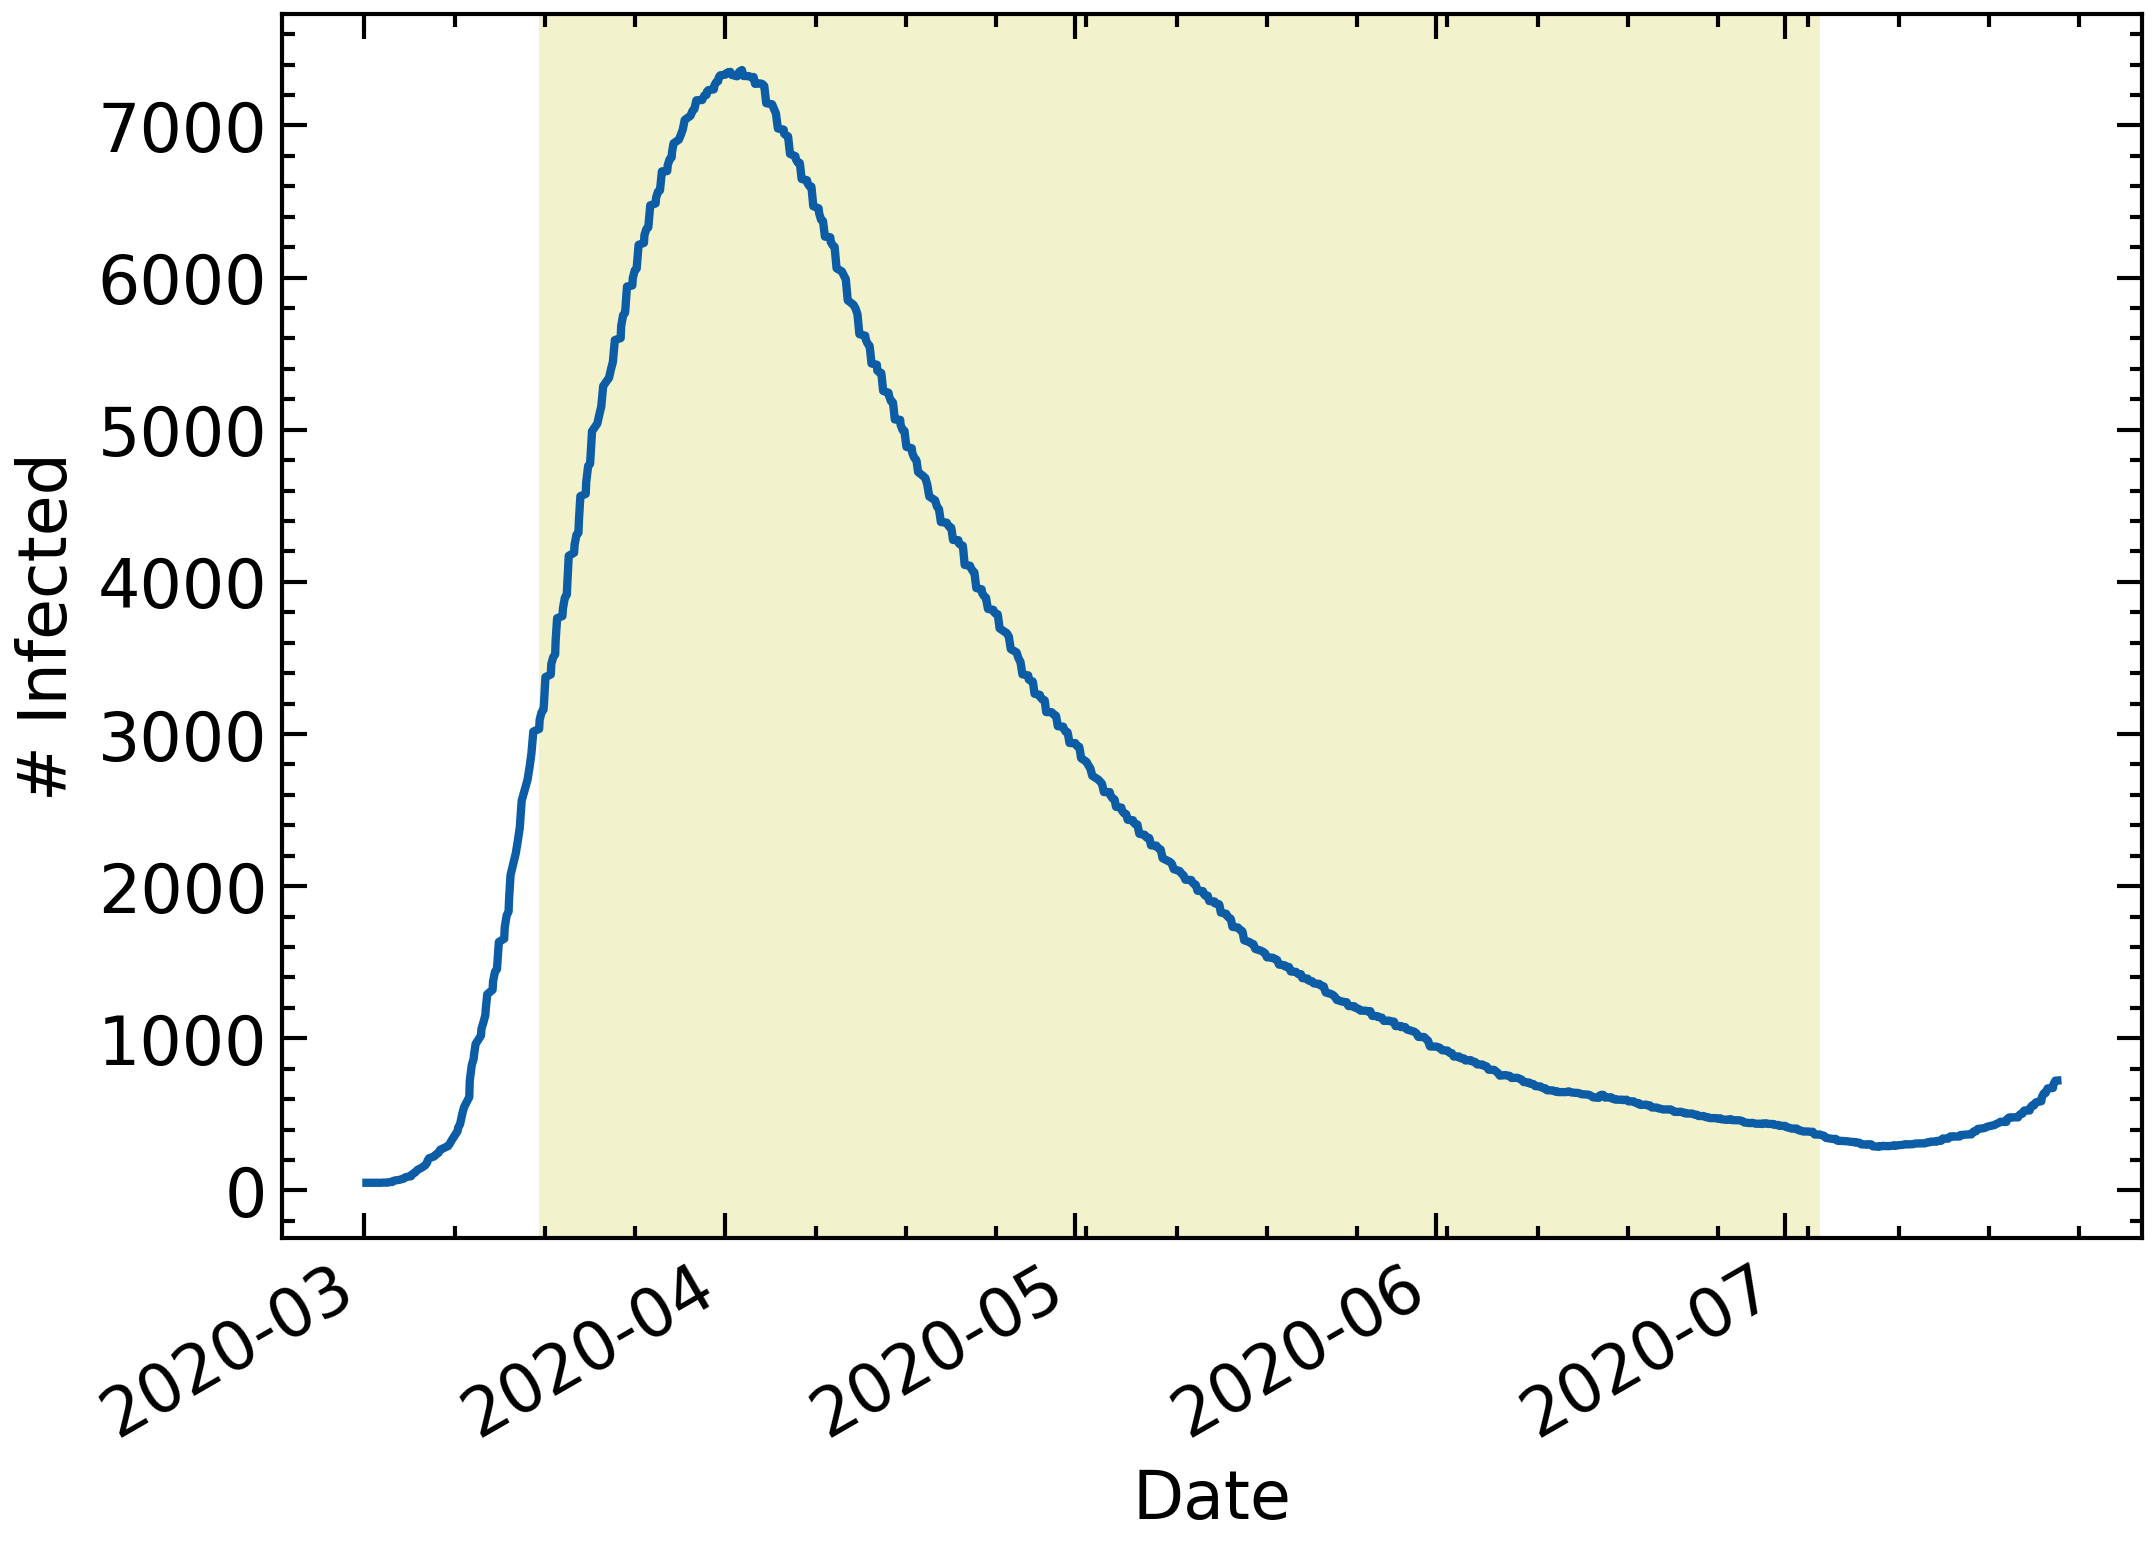

In [47]:
fig, ax = plt.subplots()
world_df['infected'].plot(ax=ax)
ax.axvspan(policies.social_distancing_start, 
            policies.social_distancing_end,
            facecolor='y', alpha=0.2)
ax.set_ylabel('# Infected')
ax.set_xlabel('Date')

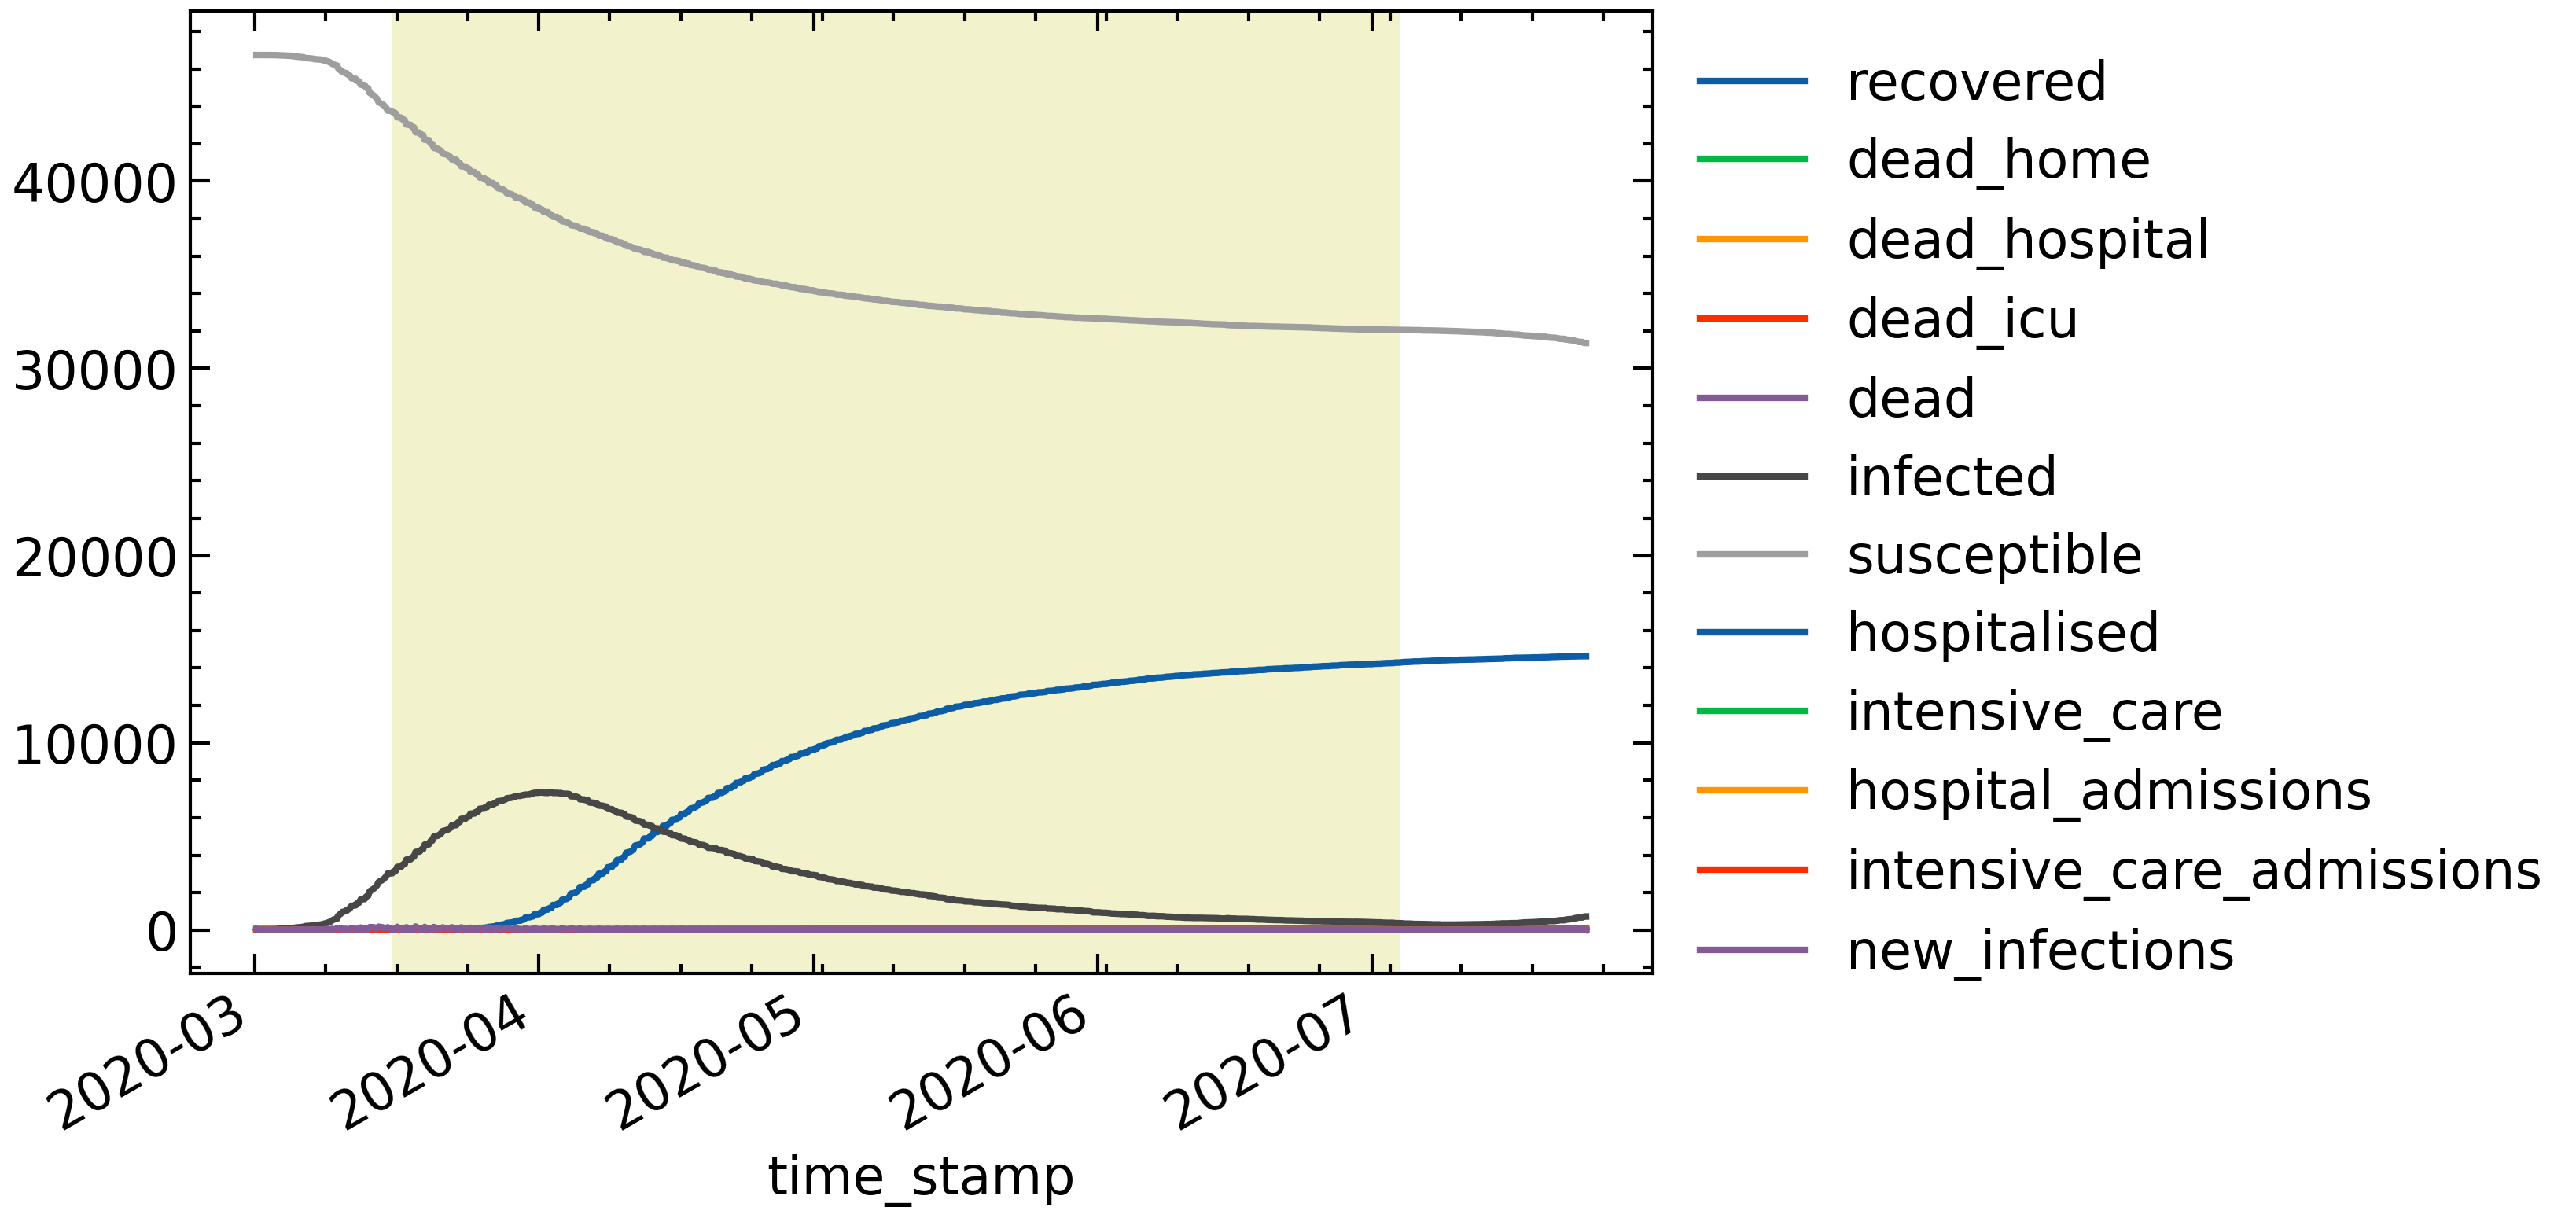

In [48]:
world_df.plot()
plt.axvspan(policies.social_distancing_start, 
            policies.social_distancing_end,
            facecolor='y', alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))


In [49]:
area_df = read.super_area_summary()

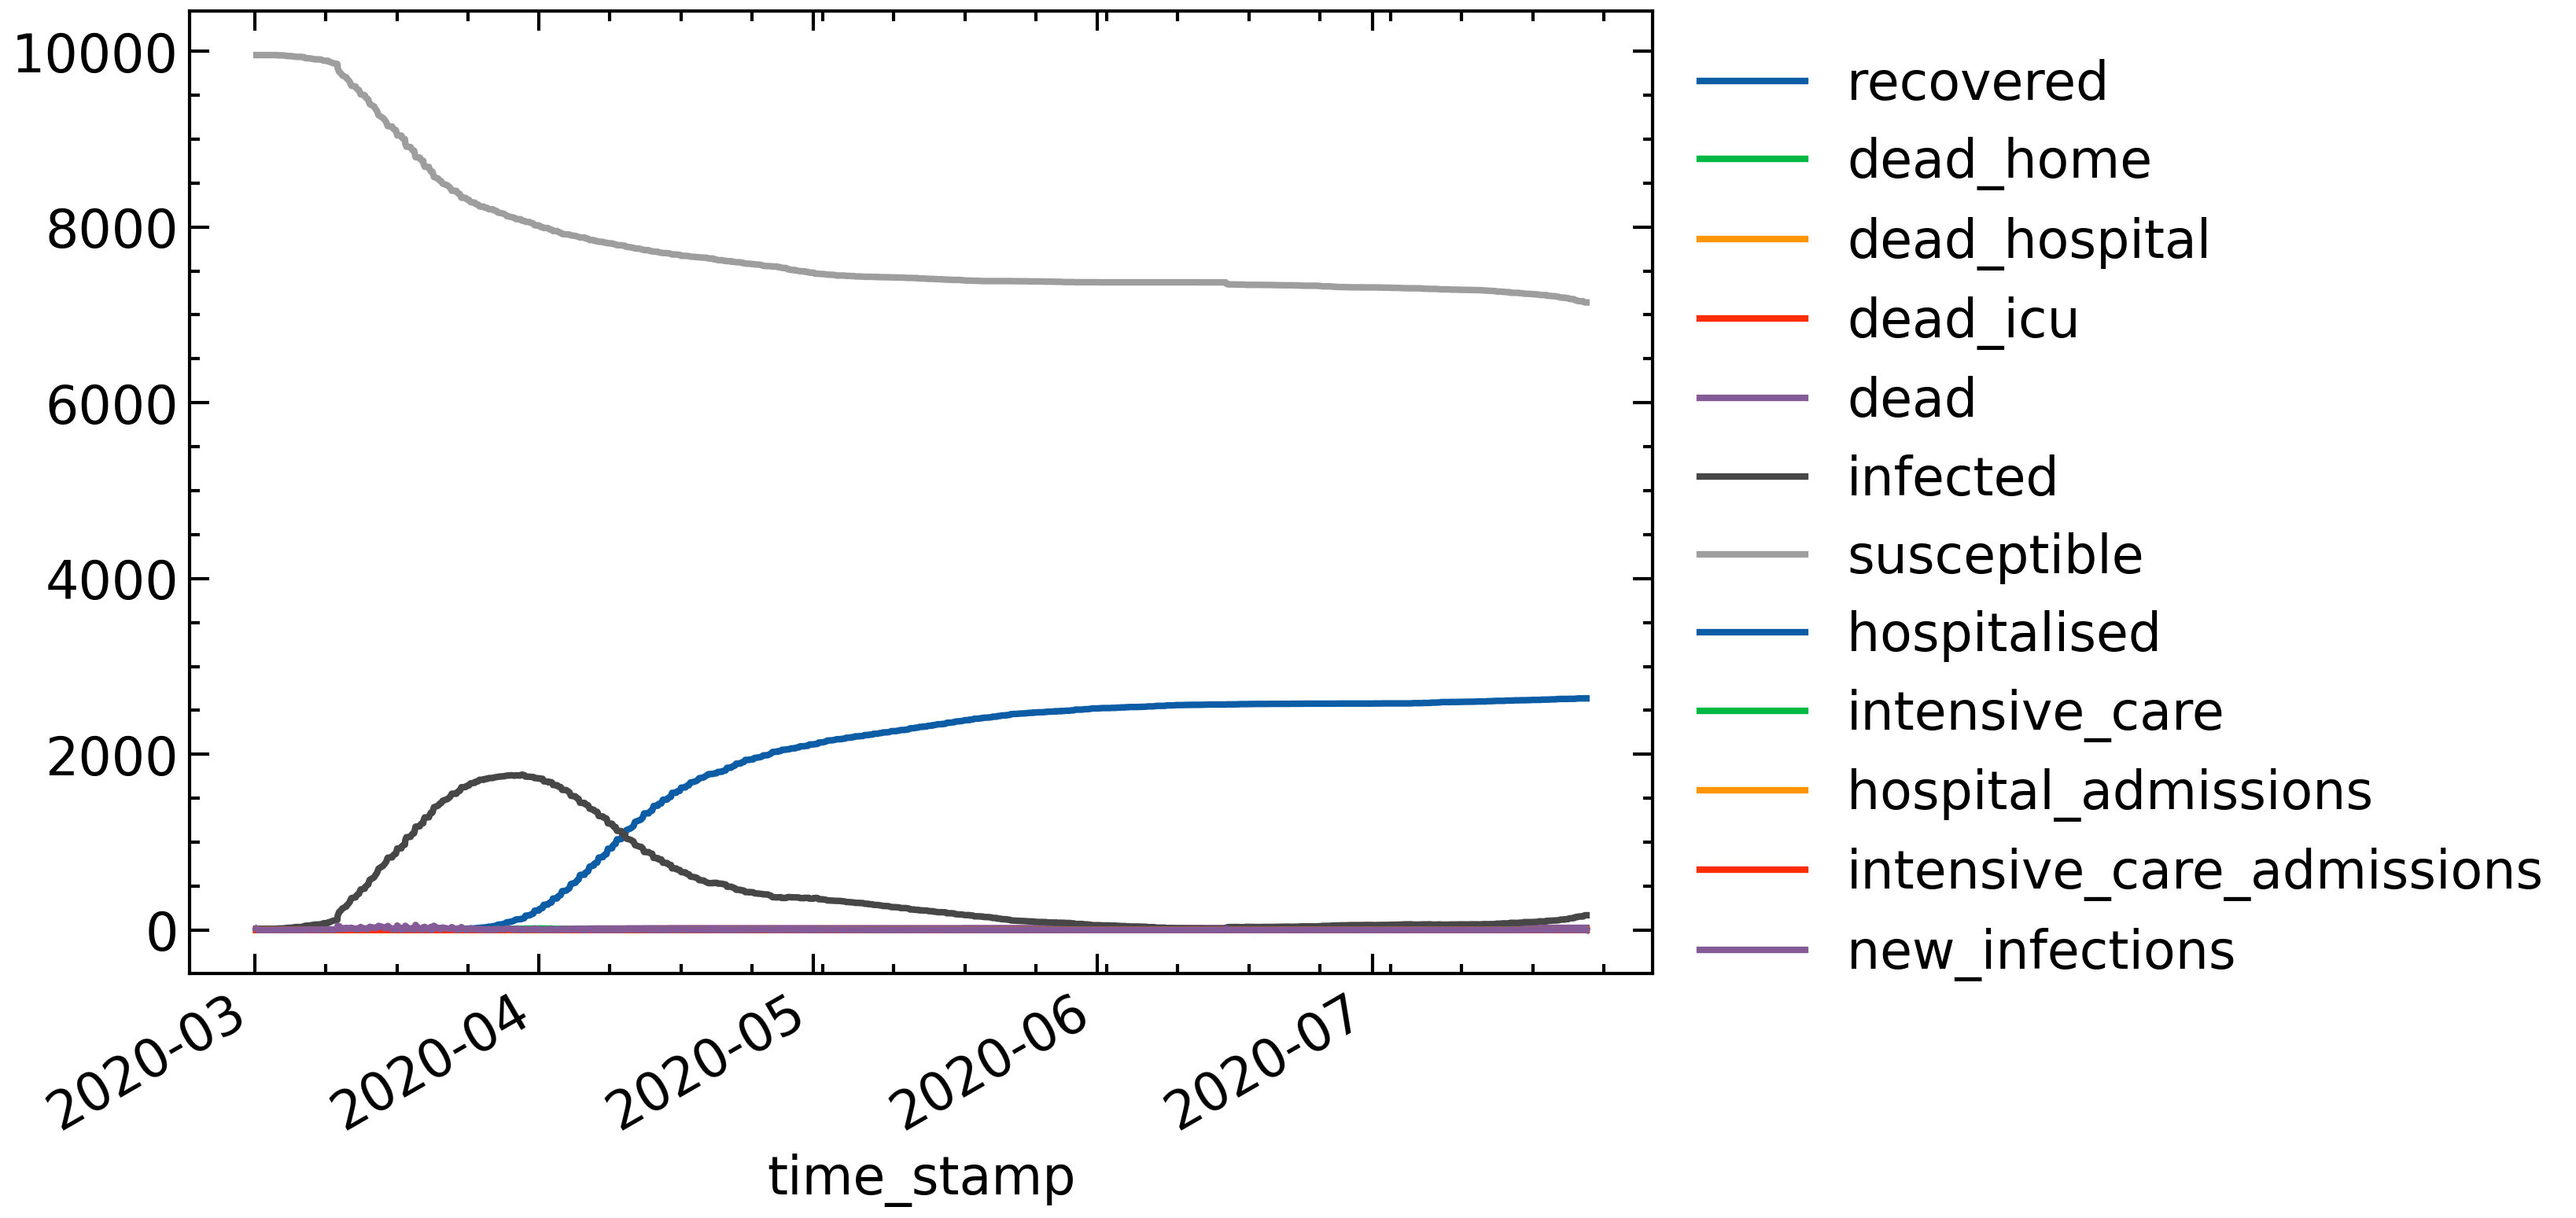

In [50]:
area_df[area_df.super_area == "E02003282"].plot()
plt.legend(bbox_to_anchor=(1,1))



## World infection curves per age group

In [51]:
ages_df = read.age_summary([0,10,20,30,40,
                  50,60,70,80,90,100])

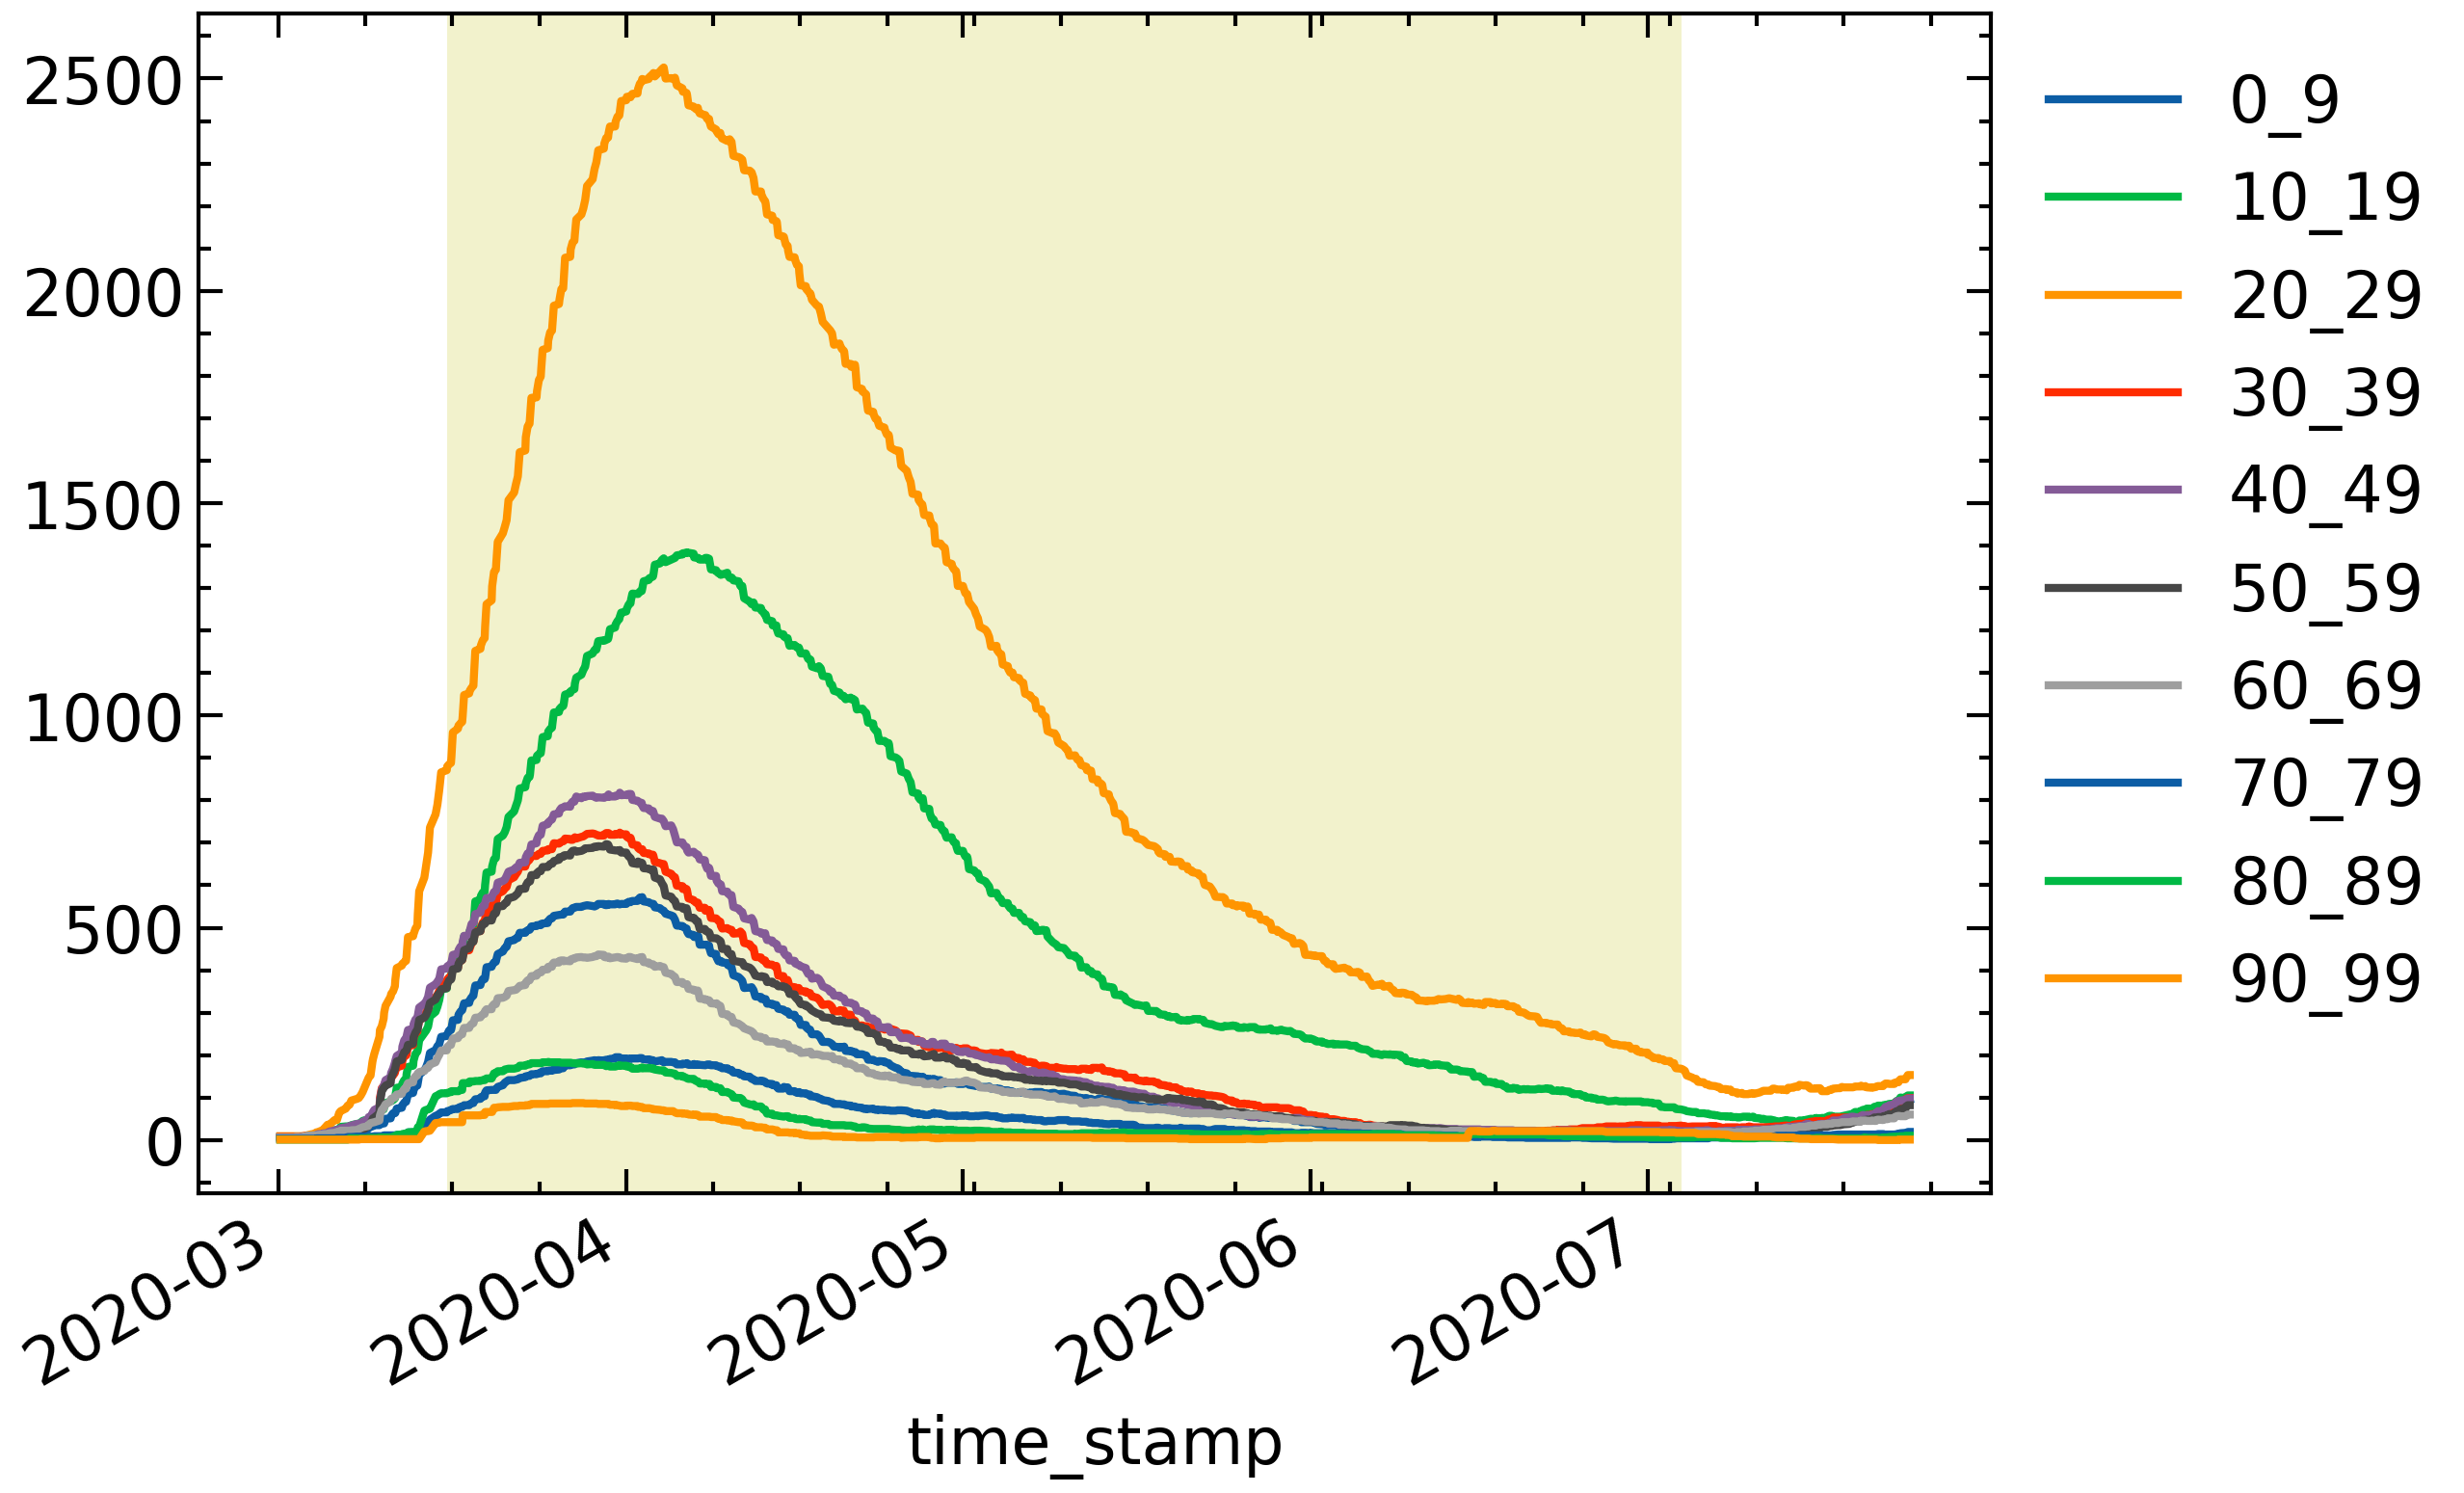

In [52]:
for name, group in ages_df.groupby('age_range'):
    group['infected'].plot(label=name)
plt.axvspan(policies.social_distancing_start, 
            policies.social_distancing_end,
            facecolor='y', alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))


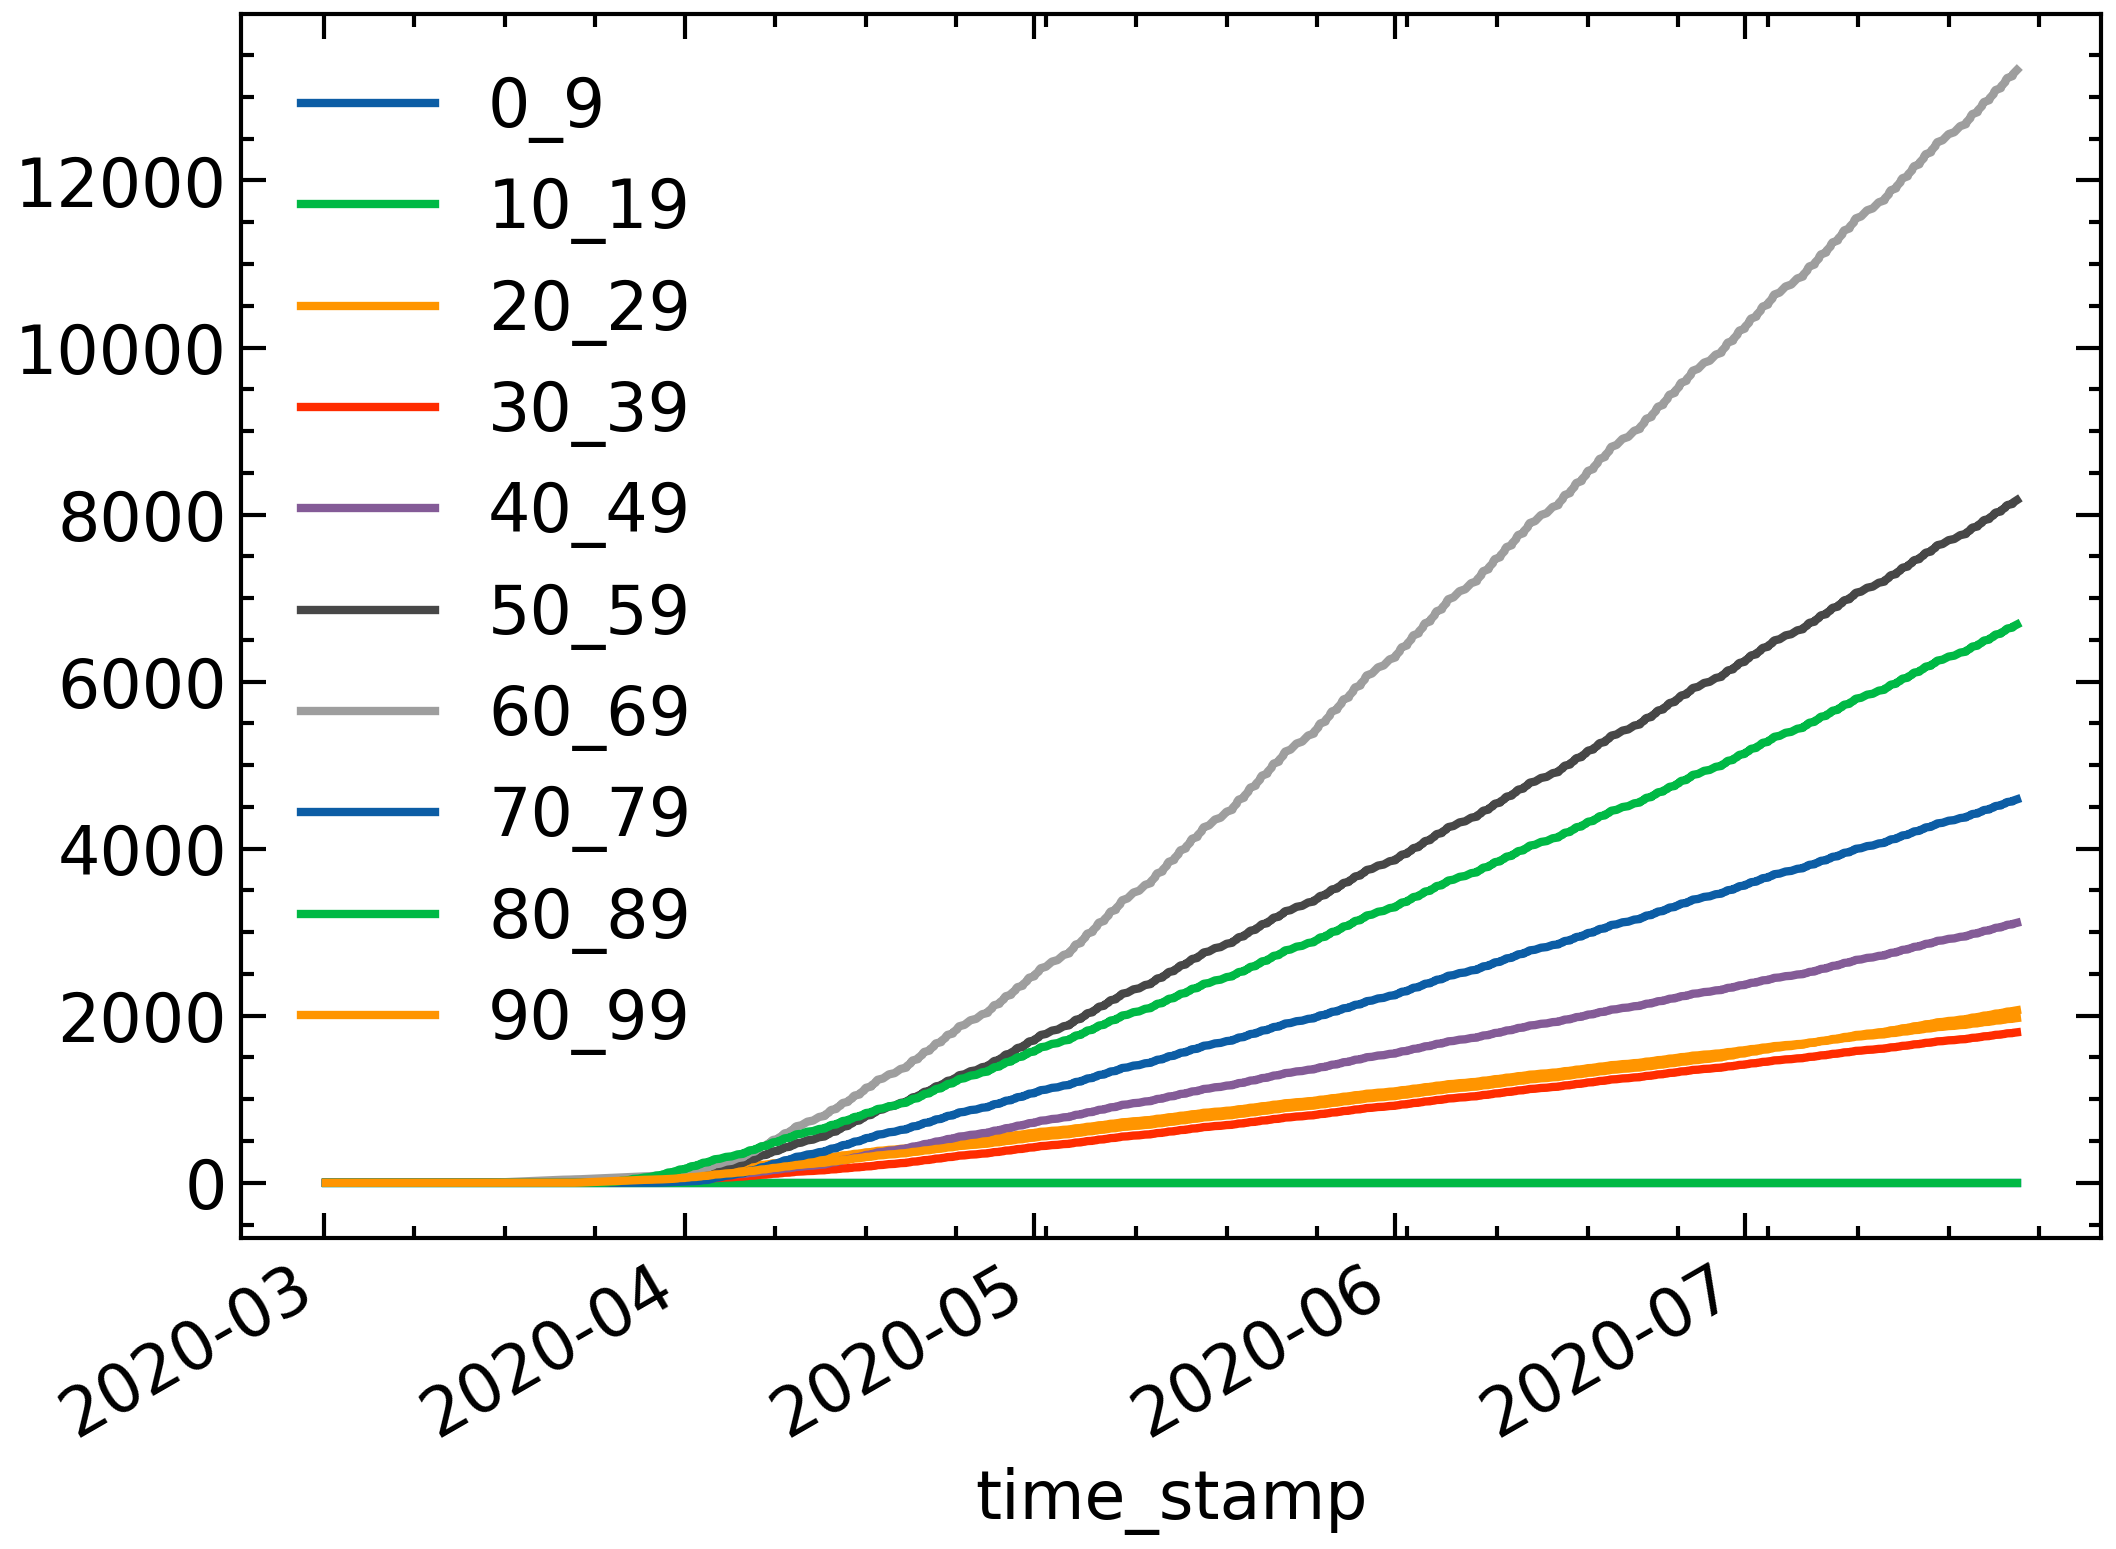

In [53]:
for name, group in ages_df.groupby('age_range'):
    group['dead'].cumsum().plot(label=name)
plt.legend()

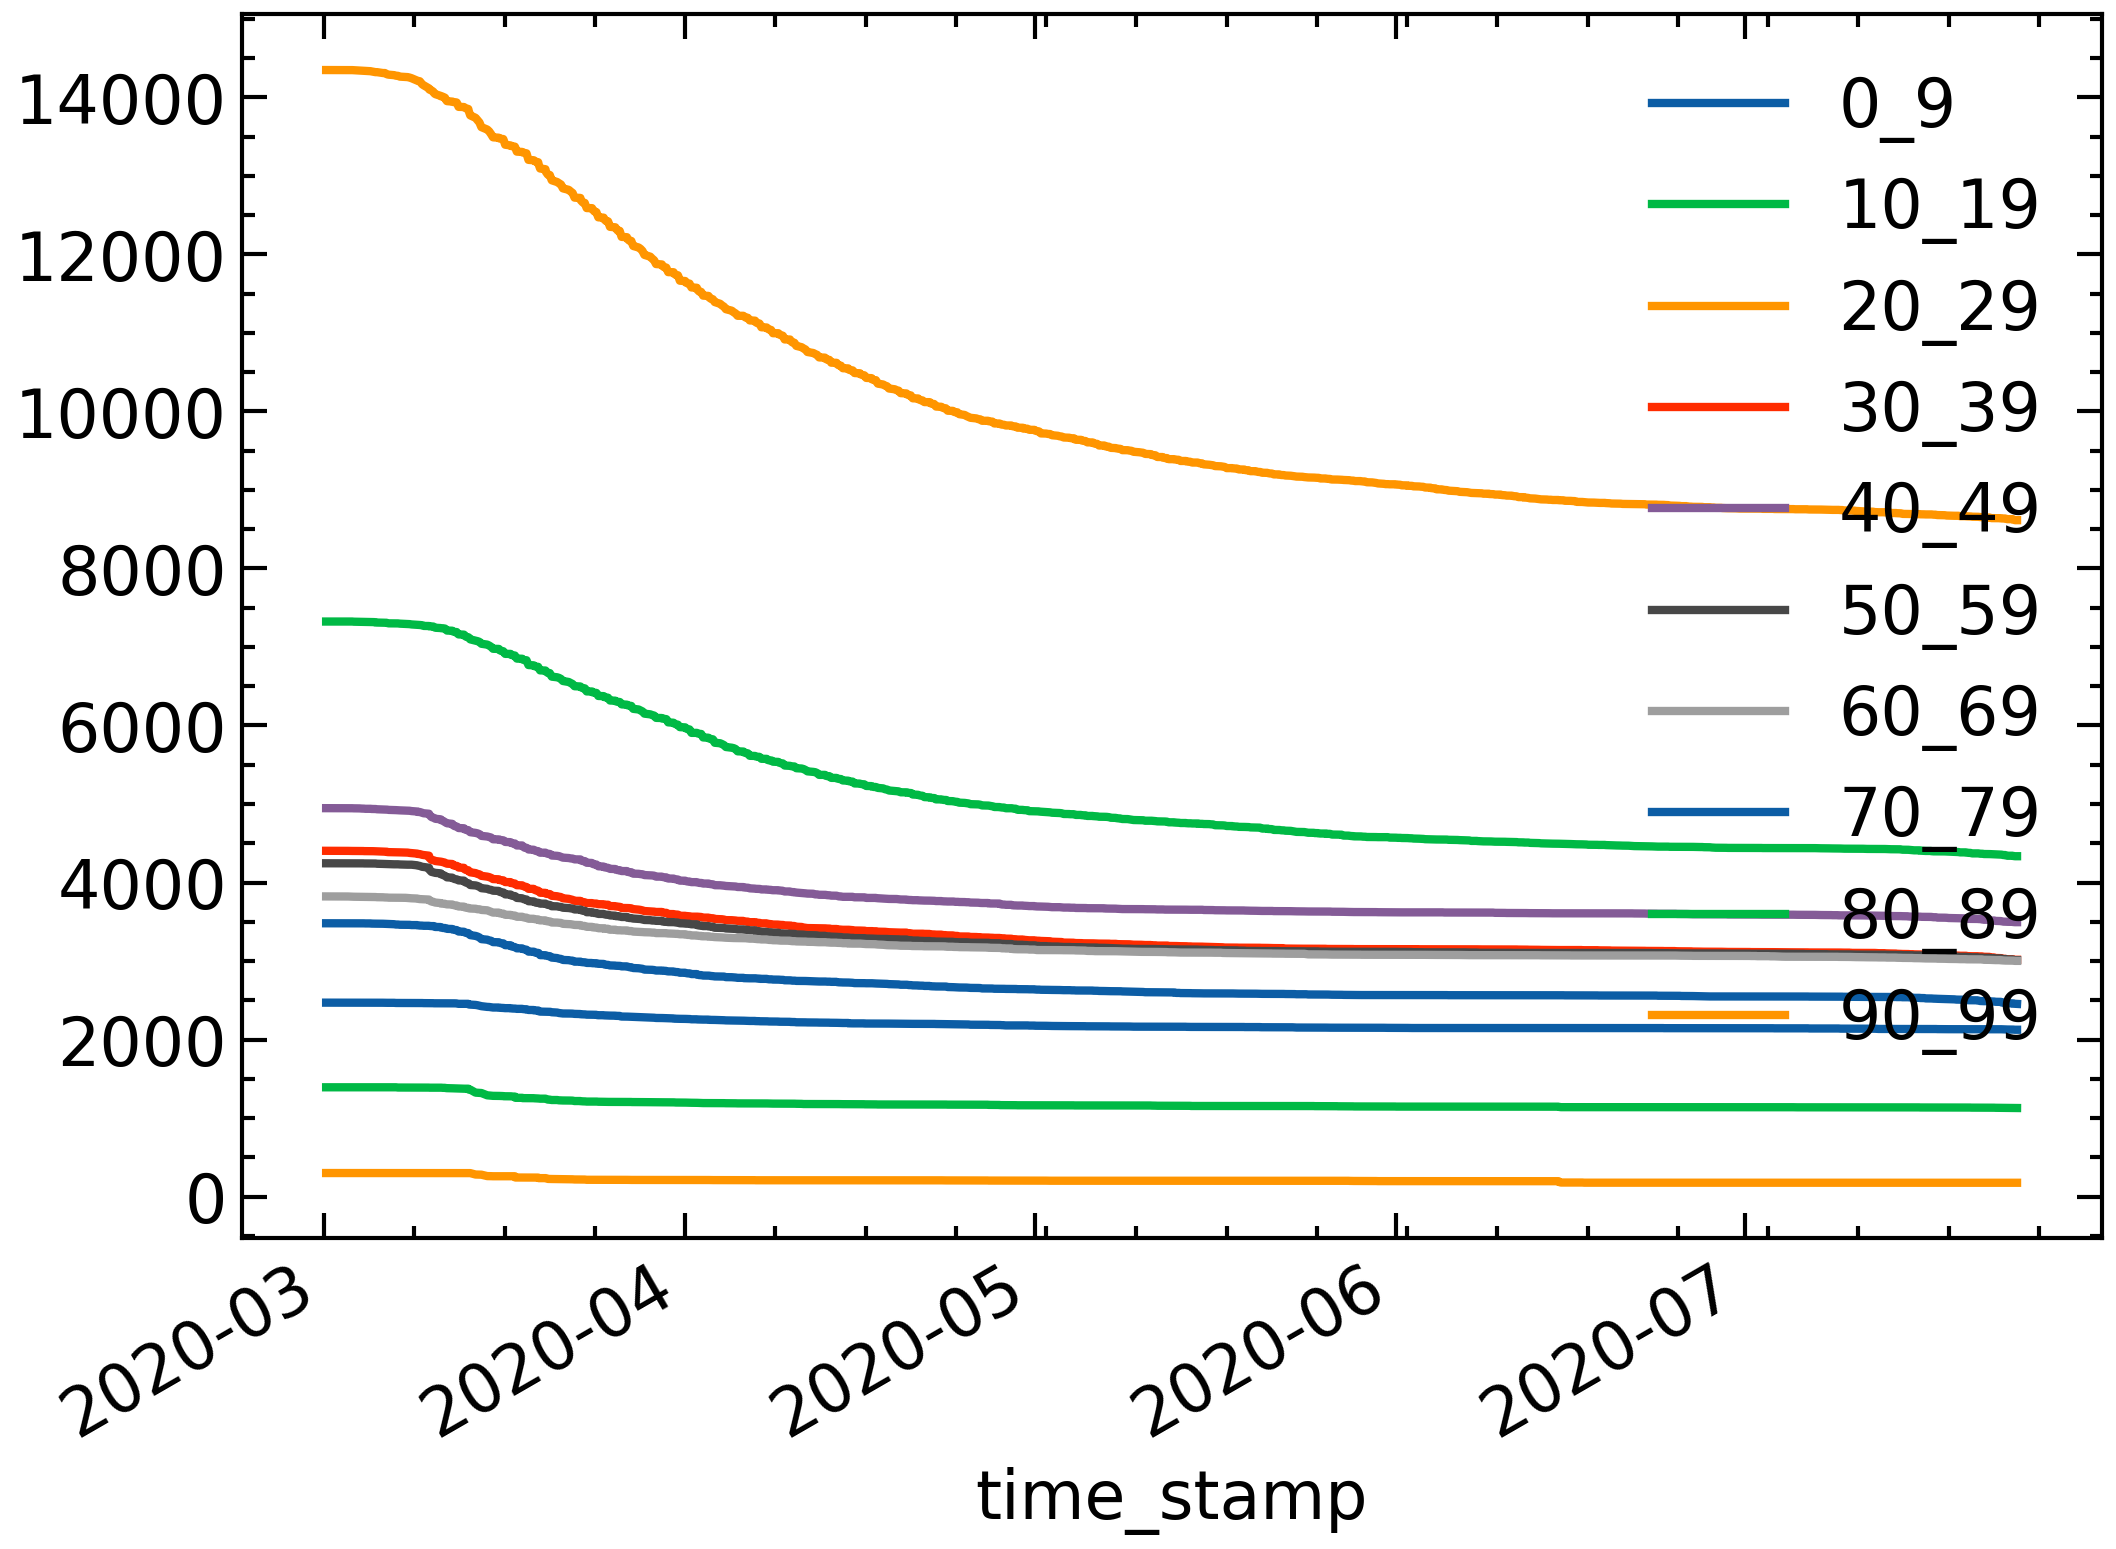

In [54]:
for name, group in ages_df.groupby('age_range'):
    group['susceptible'].plot(label=name)
plt.legend()

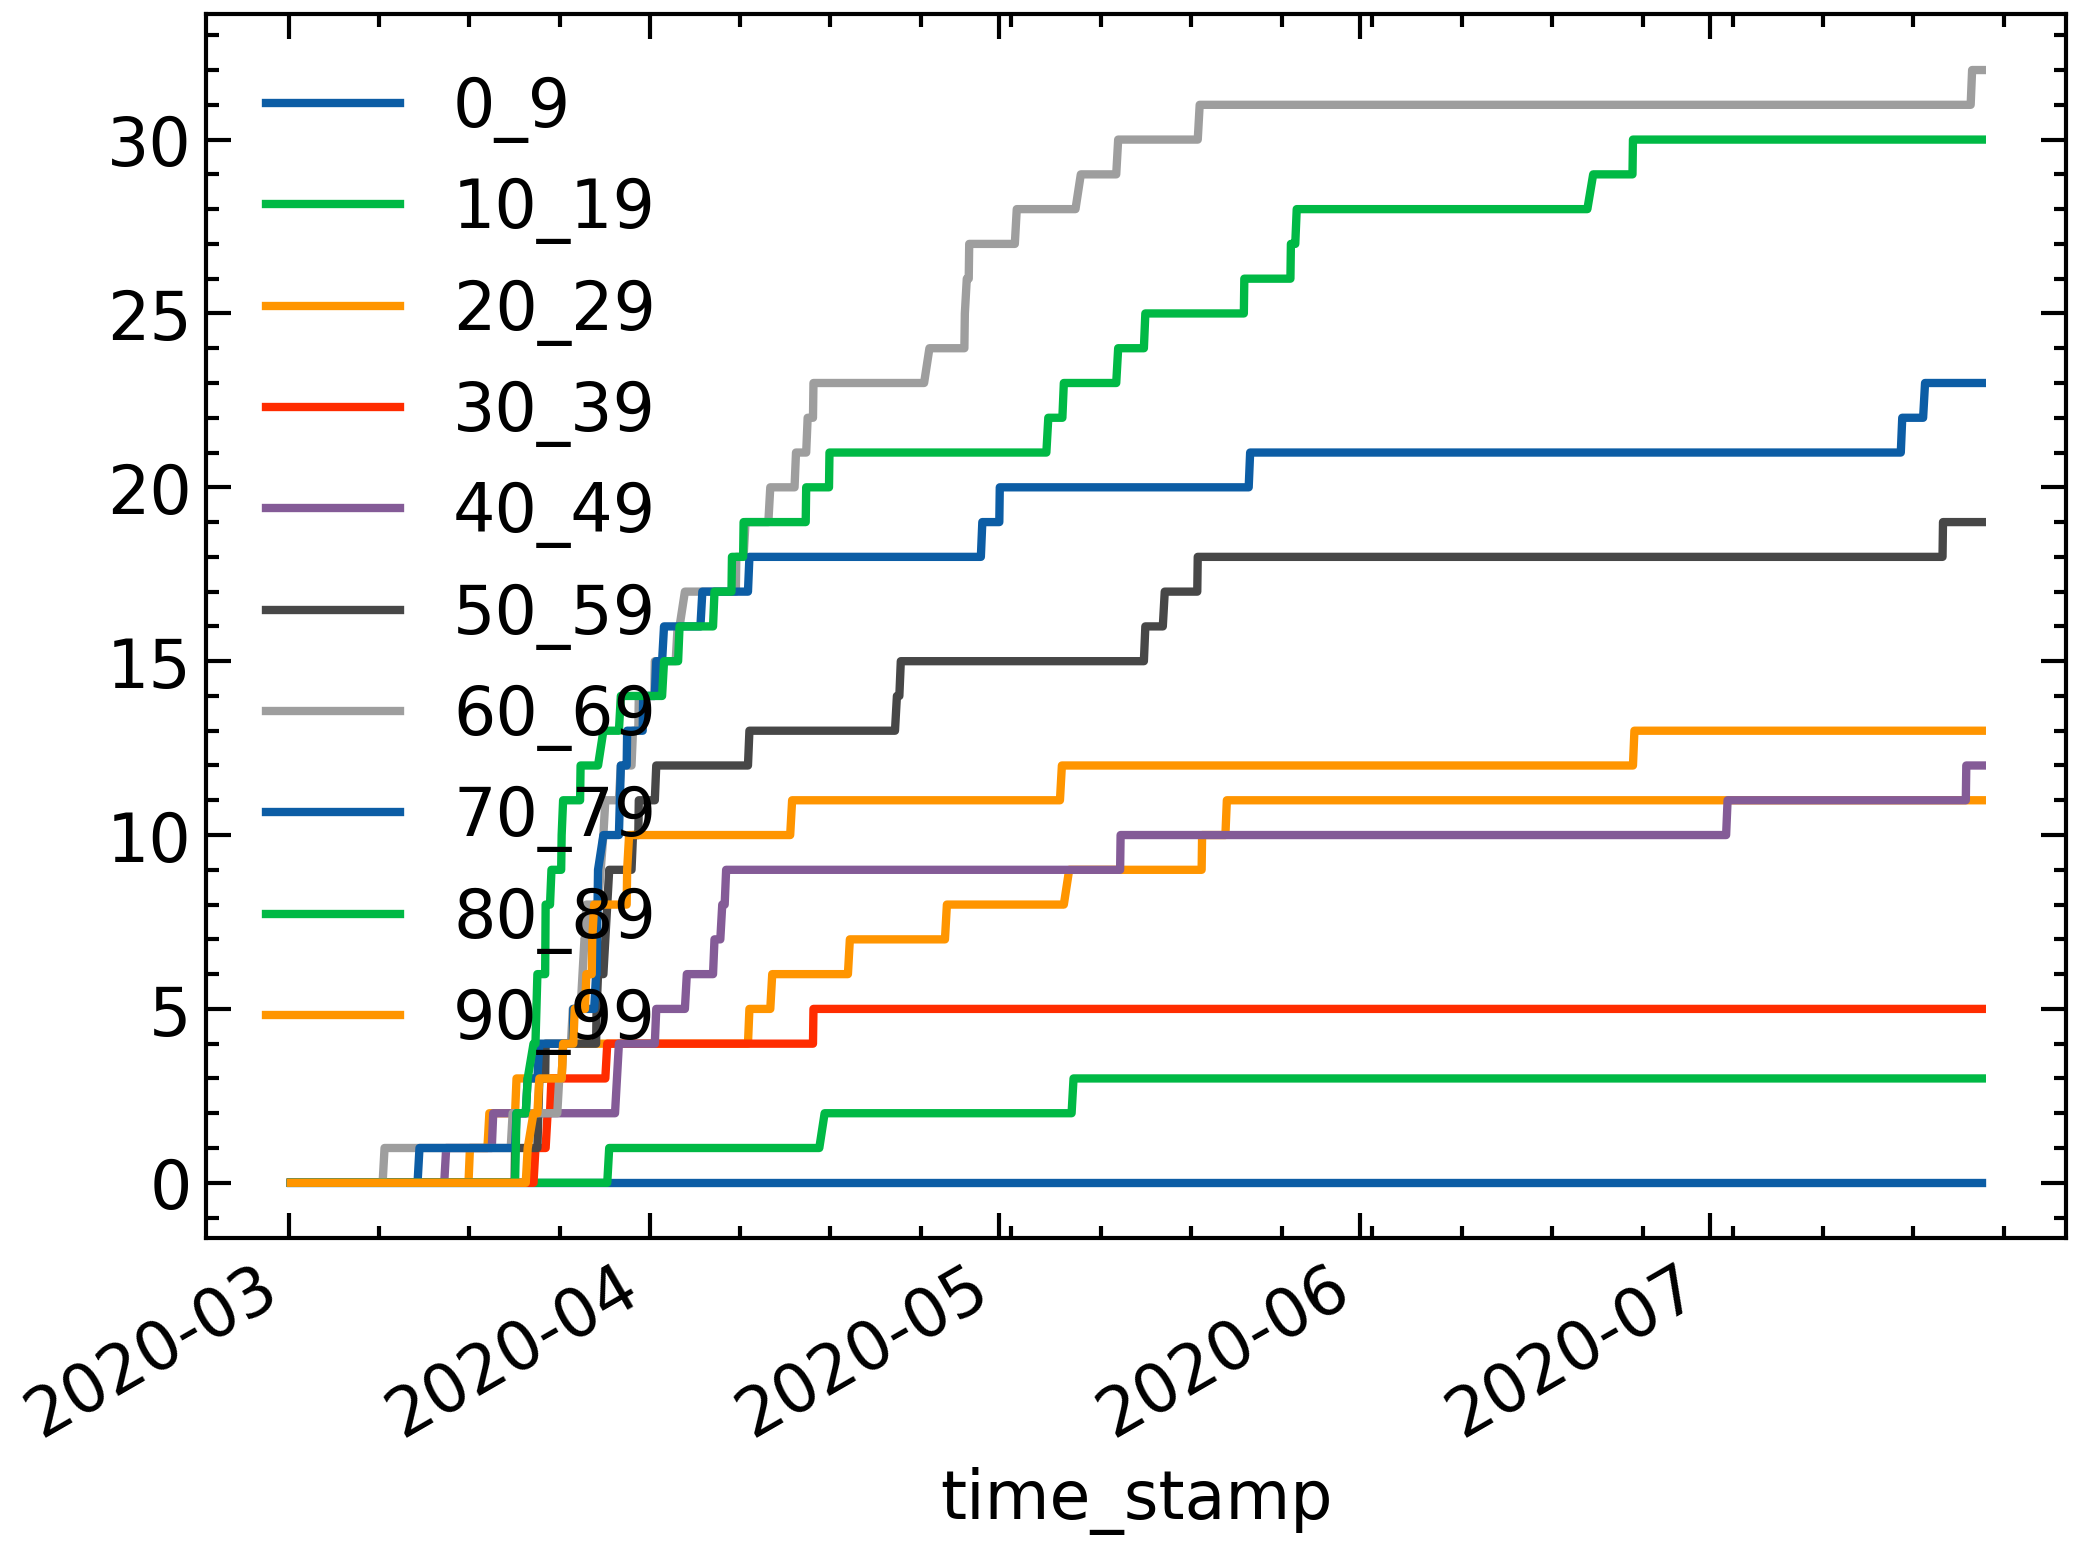

In [55]:
for name, group in ages_df.groupby('age_range'):
    group['hospital_admissions'].cumsum().plot(label=name)
plt.legend()

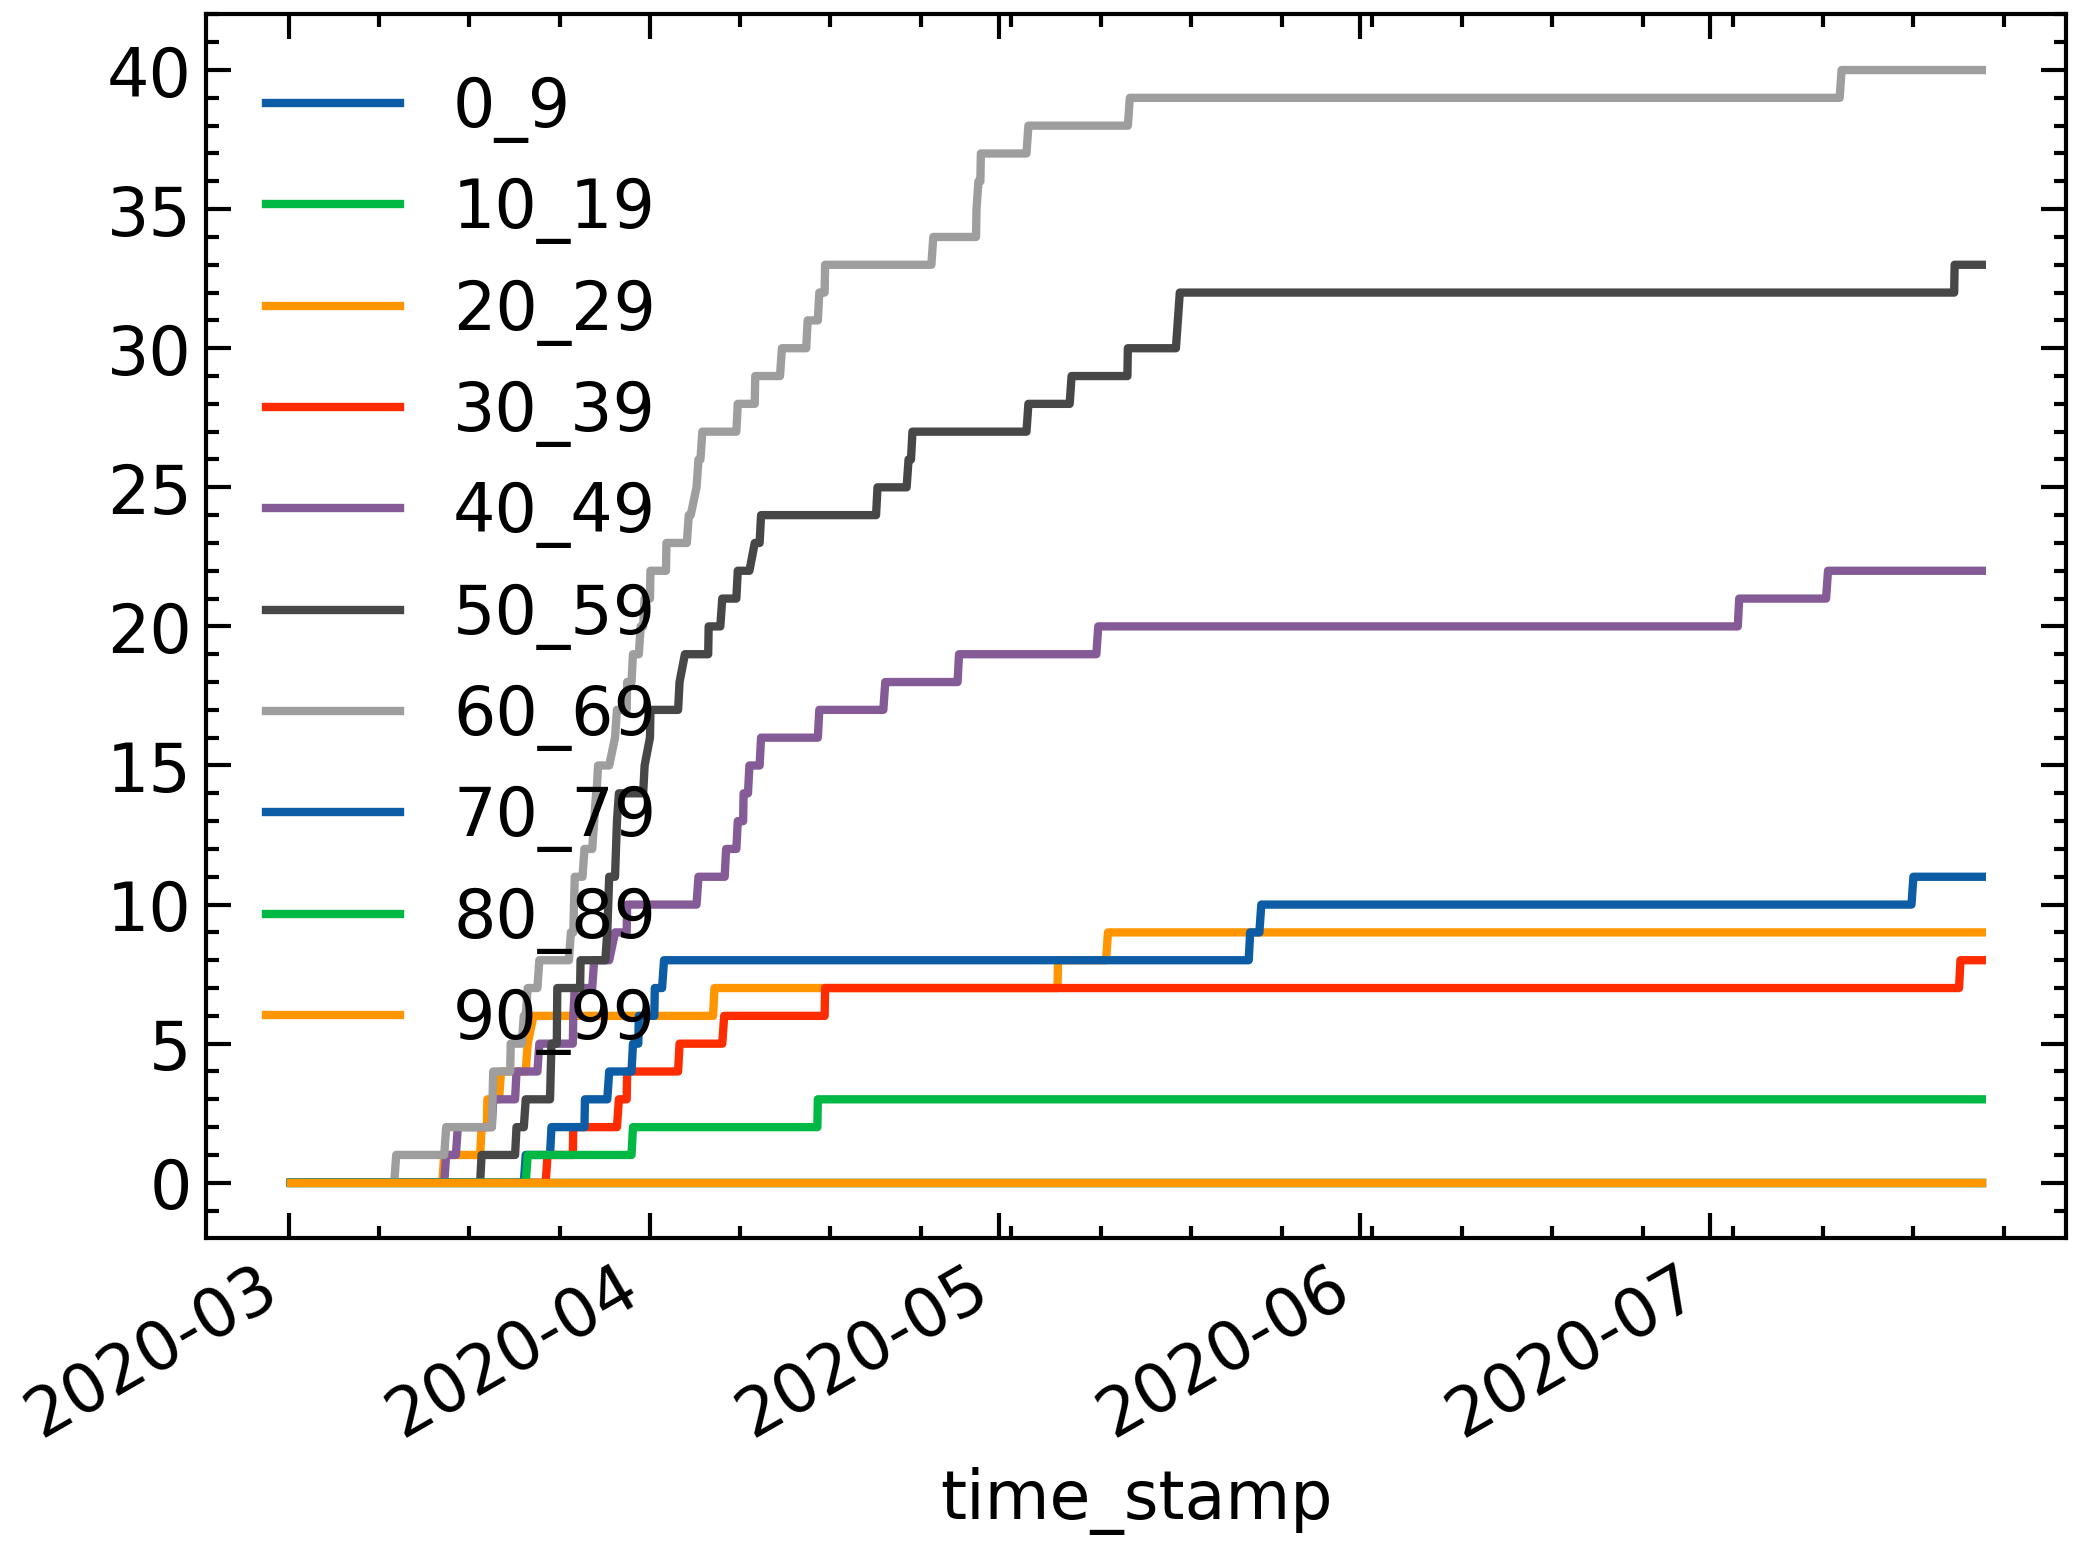

In [56]:
for name, group in ages_df.groupby('age_range'):
    group['intensive_care_admissions'].cumsum().plot(label=name)
plt.legend()

## Draw some of the symptoms trajectories

In [62]:
random_trajectories = read.draw_symptom_trajectories(window_length=600,
                                        n_people=10)

In [63]:
from june.infection import SymptomTag

In [64]:
symptoms_values = [tag.value for tag in SymptomTag]
symptoms_names = [tag.name for tag in SymptomTag]


Text(0.5, 0, 'Date')

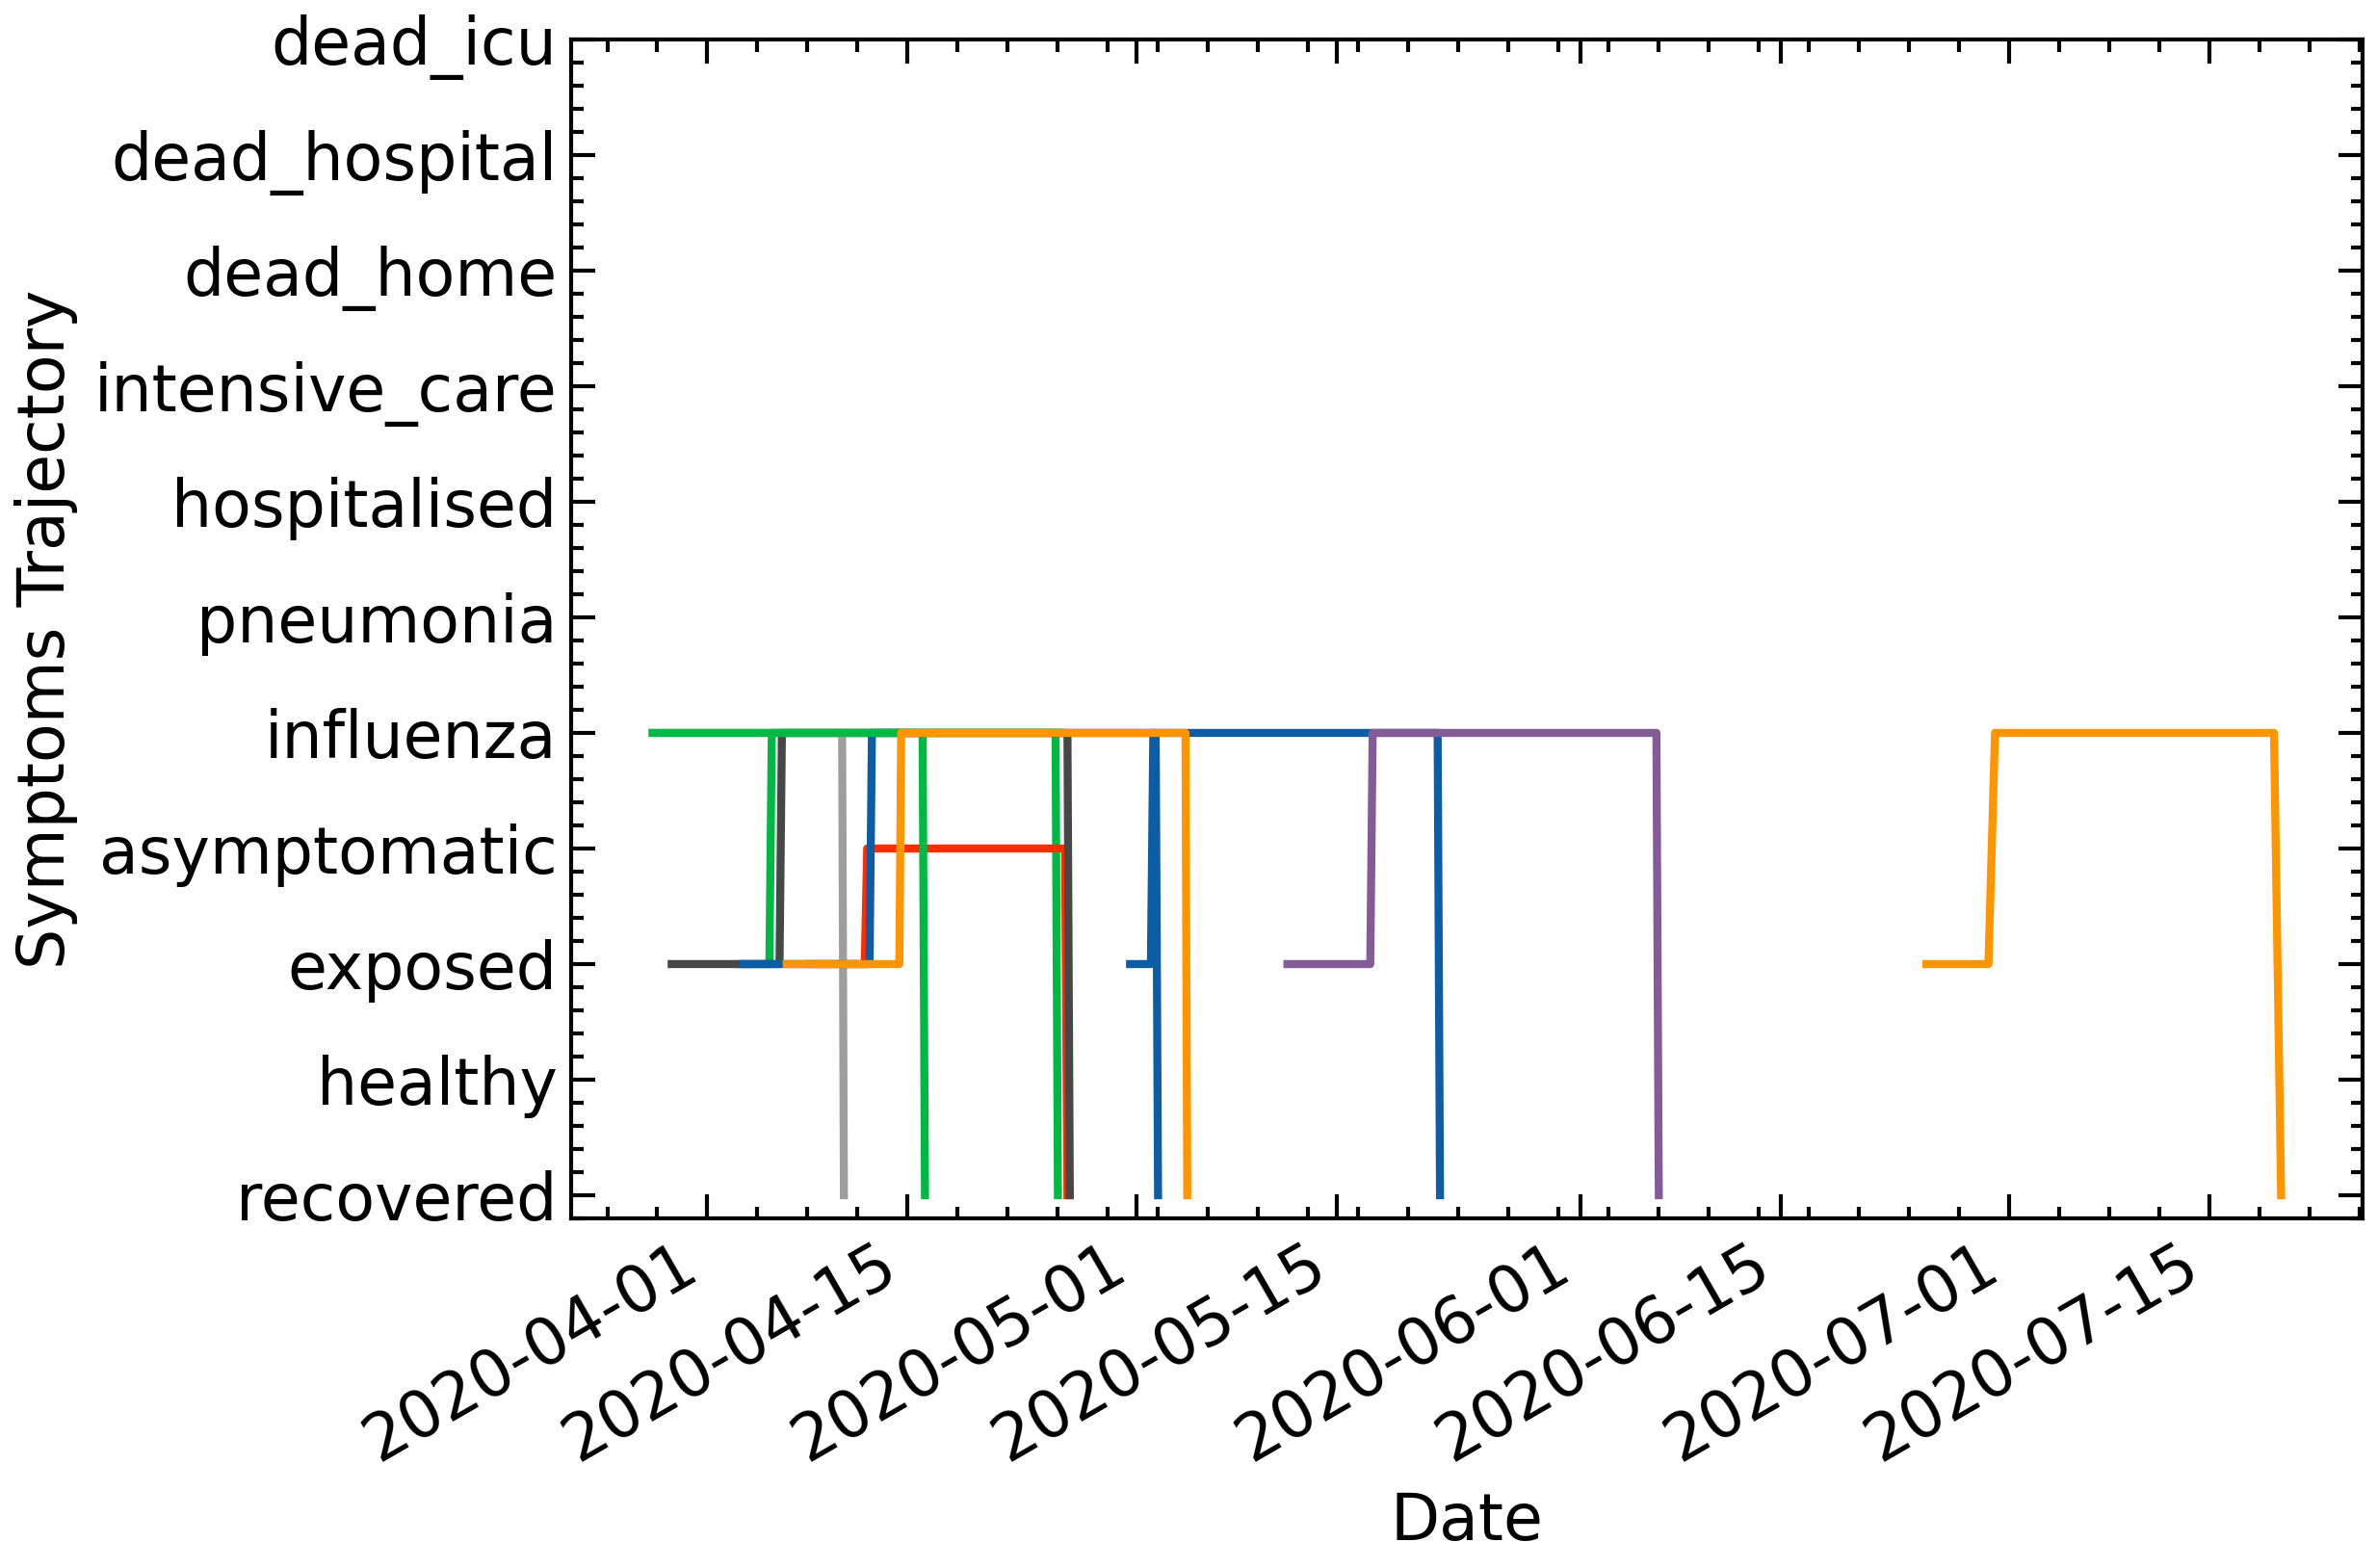

In [65]:
for df_person in random_trajectories:
    df_person['symptoms'].plot()
plt.ylabel('Symptoms Trajectory')
_ = plt.yticks(symptoms_values, symptoms_names)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

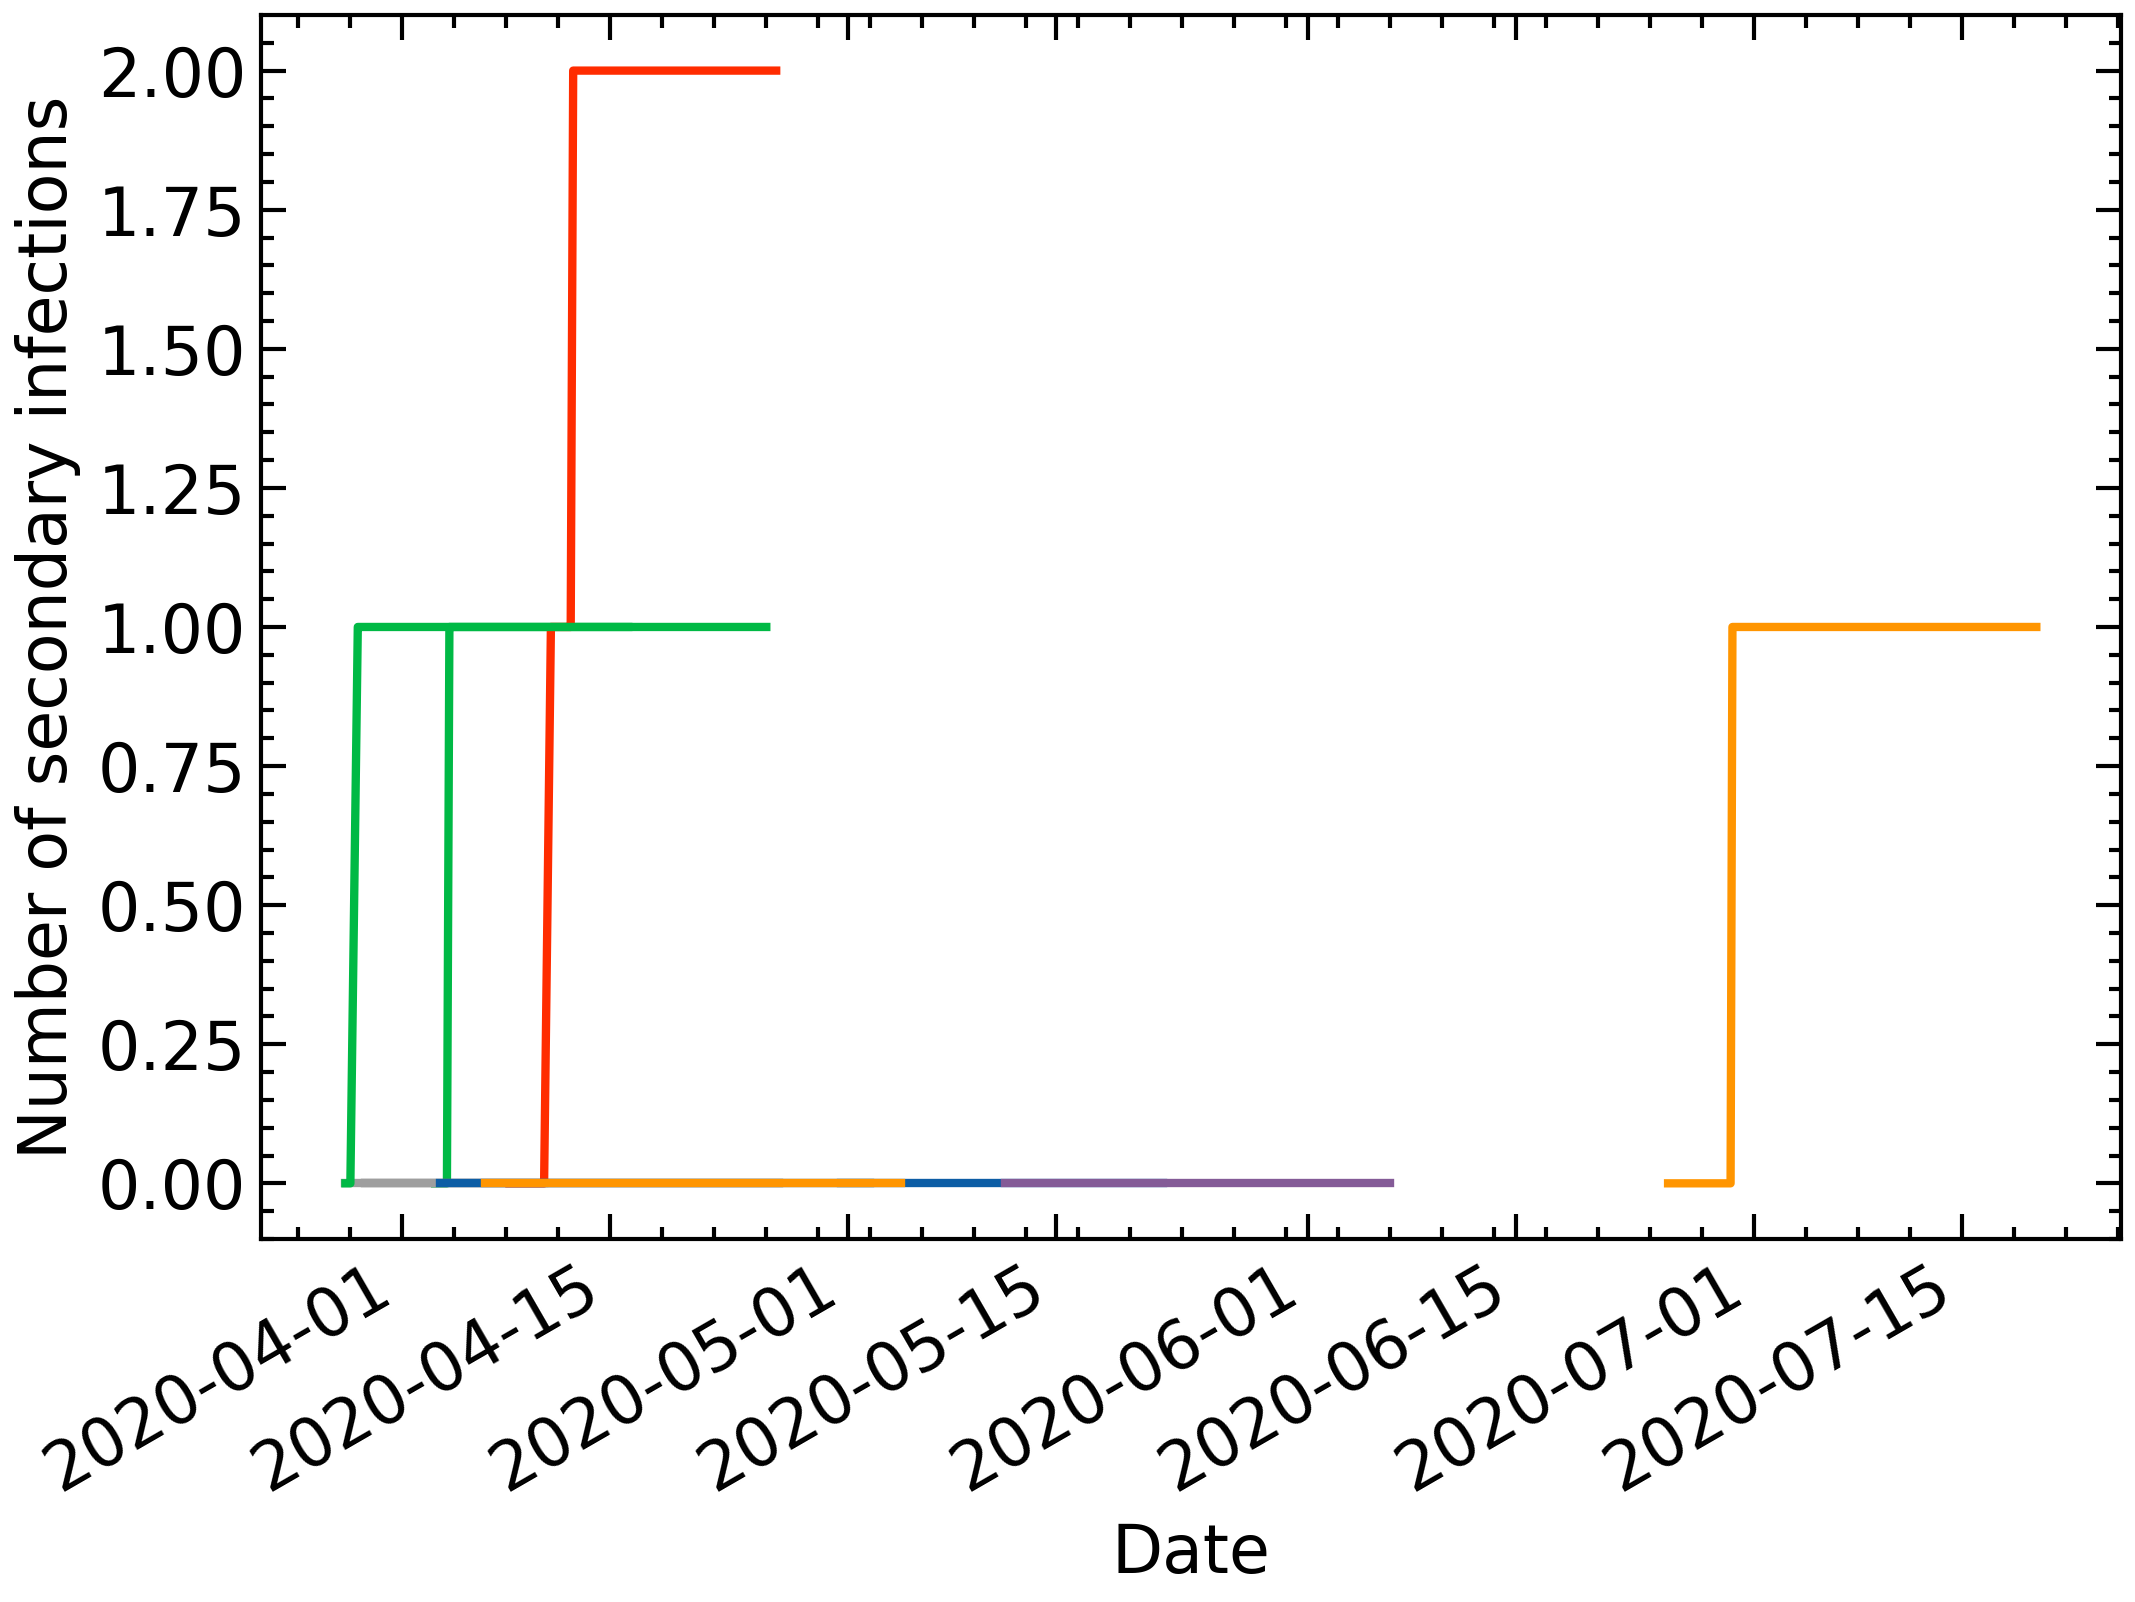

In [66]:
for df_person in random_trajectories:
    df_person['n_secondary_infections'].plot()
plt.ylabel('Number of secondary infections')

plt.xlabel('Date')